## 패키지 불러오기

In [1]:
import os
os.chdir("Y:\Python\Mega_IT\E.Inferential_statistics/5.Logistic_Regression")
os.getcwd()

'Y:\\Python\\Mega_IT\\E.Inferential_statistics\\5.Logistic_Regression'

In [2]:
import sys
import os
work_path = os.path.abspath(os.path.join(os.getcwd(), "../.."))
sys.path.append(work_path)

from my_helper.regression import *
from my_helper.util import *
from my_helper.plot import *
from my_helper.analysis import *
from my_helper.classification import *
from yjk_module.preprocessing import *
from yjk_module.ml_module import *

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb

from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split, learning_curve, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, log_loss, confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, f1_score, roc_curve, precision_recall_curve

## 데이터 불러오기

In [3]:
origin = pd.read_excel('./data/telecom_customer.xlsx')

In [4]:
df = origin.copy()
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


## EDA

- 데이터 크기

In [5]:
df.shape

(7043, 21)

- 데이터 요약

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


- 기초통계량

In [7]:
df.describe()

,SeniorCitizen,tenure,MonthlyCharges
count,7043.000000,7043.000000,7043.000000
mean,0.162147,32.371149,64.761692
std,0.368612,24.559481,30.090047
min,0.000000,0.000000,18.250000
25%,0.000000,9.000000,35.500000
50%,0.000000,29.000000,70.350000
75%,0.000000,55.000000,89.850000
max,1.000000,72.000000,118.750000


In [8]:
df.describe(include = 'O').T

,count,unique,top,freq
customerID,7043,7043,7590-VHVEG,1
gender,7043,2,Male,3555
Partner,7043,2,No,3641
Dependents,7043,2,No,4933
PhoneService,7043,2,Yes,6361
MultipleLines,7043,3,No,3390
InternetService,7043,3,Fiber optic,3096
OnlineSecurity,7043,3,No,3498
OnlineBackup,7043,3,No,3088
DeviceProtection,7043,3,No,3095


- SeniorCitizen의 경우 0, 1 2종류 데이터만 있으므로 명목형 변수로 보아도 무방함
- customerID는 고객 고유 ID로 모든 열이 다른 데이터로 분석에 무의미하기 때문에 삭제
- TotalCharges의 경우 수치형 데이터로 추정되나 object 타입으로 분류되어 별도의 데이터 정제가 필요해보임

In [9]:
df['SeniorCitizen'].value_counts()

0    5901
1    1142
Name: SeniorCitizen, dtype: int64

In [10]:
df['SeniorCitizen'] = df['SeniorCitizen'].map({0 : 'No', 1 : 'Yes'})

In [11]:
df.drop('customerID', axis = 1, inplace = True)

- TotalCharge 컬럼 확인
    - 공란 데이터가 존재하며 이는 결측치로 판단하고 np.nan으로 대체

In [12]:
df['TotalCharges'].value_counts()

          11
20.2      11
19.75      9
20.05      8
19.9       8
          ..
6849.4     1
692.35     1
130.15     1
3211.9     1
6844.5     1
Name: TotalCharges, Length: 6531, dtype: int64

In [13]:
tmp_txt = df['TotalCharges'].value_counts().index[0]
df['TotalCharges'] = df['TotalCharges'].apply(lambda x : np.nan if x == tmp_txt else x)

- 수치형 데이터 Boxplot 확인

In [14]:
col_n = df.select_dtypes('number').columns
col_o = df.drop('Churn', axis = 1).select_dtypes(['object', 'category']).columns

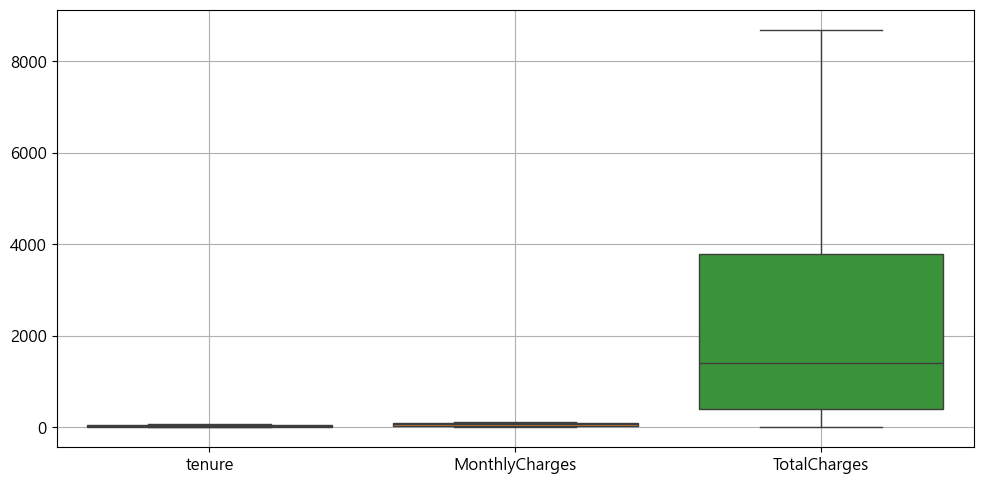

In [15]:
my_boxplot(df[col_n])

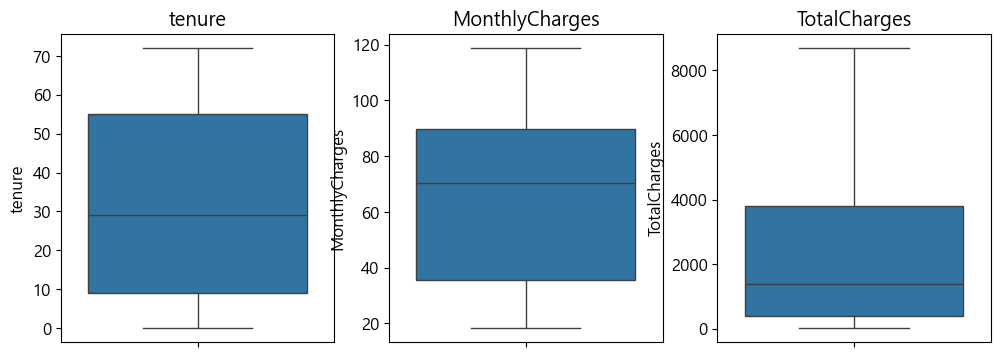

In [16]:
fig, ax = plt.subplots(1, len(col_n), figsize = (12, 4))
for i, v in enumerate(col_n):
    sb.boxplot(data = df[v], ax = ax[i])
    ax[i].set_title(v)
plt.show()

- 이상치는 없으며 데이터의 단위가 다르므로 스케일링이 필요함

- 범주형 변수 분포 확인

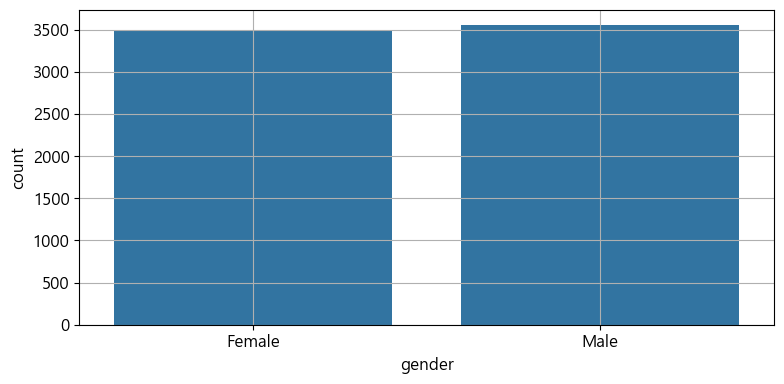

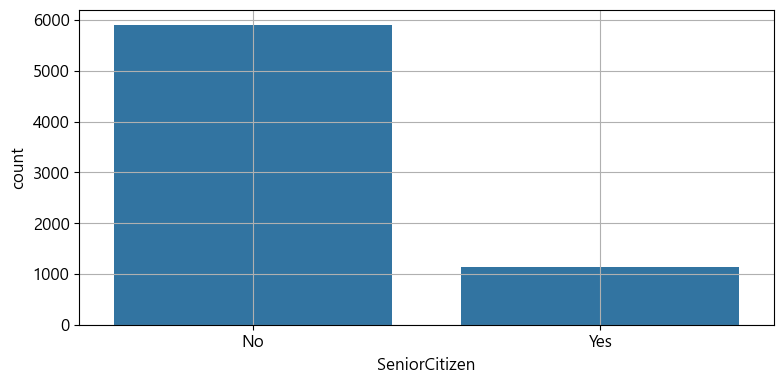

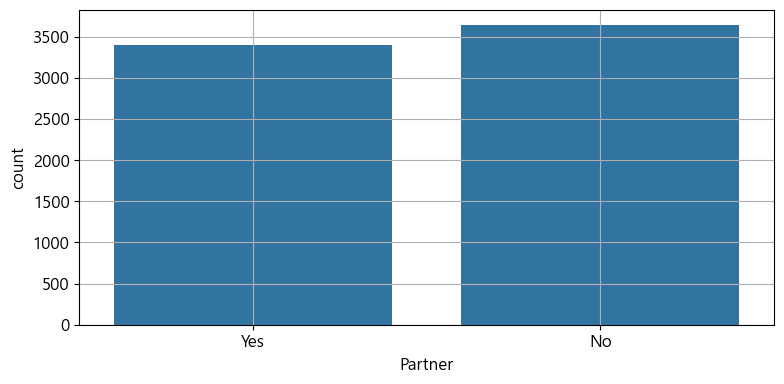

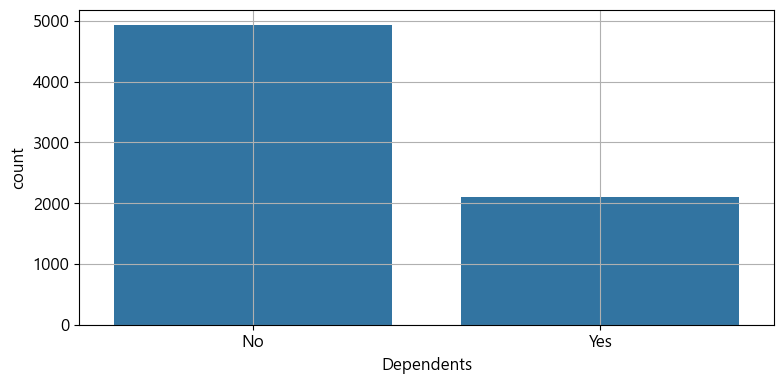

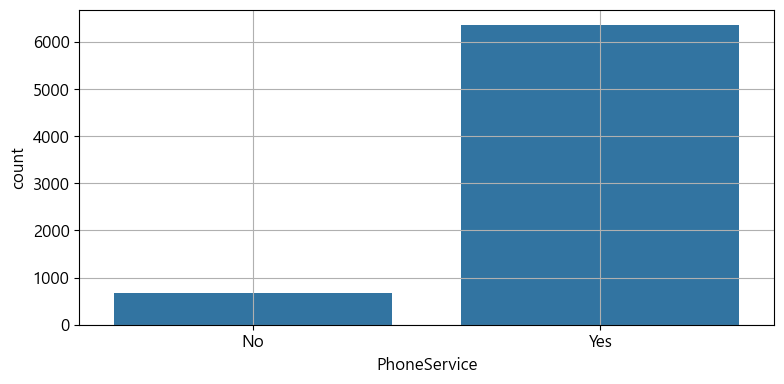

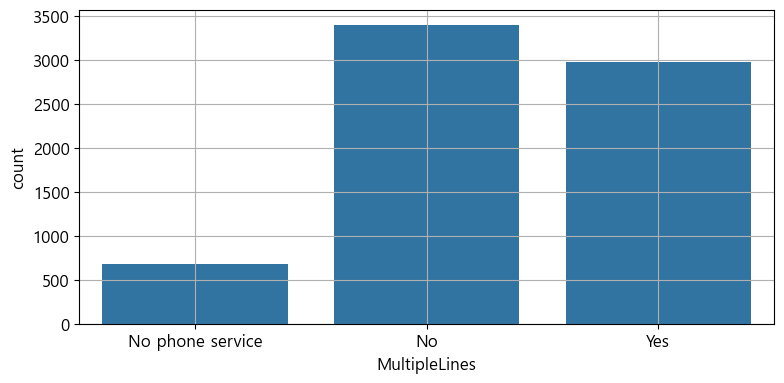

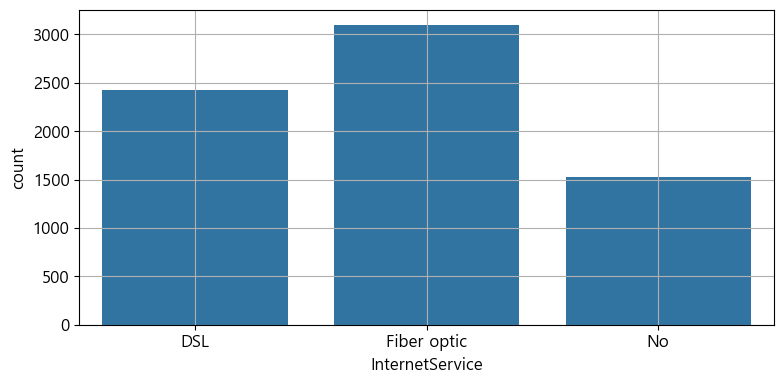

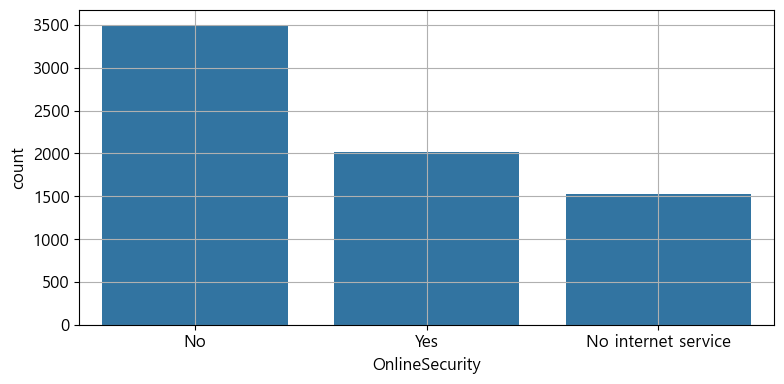

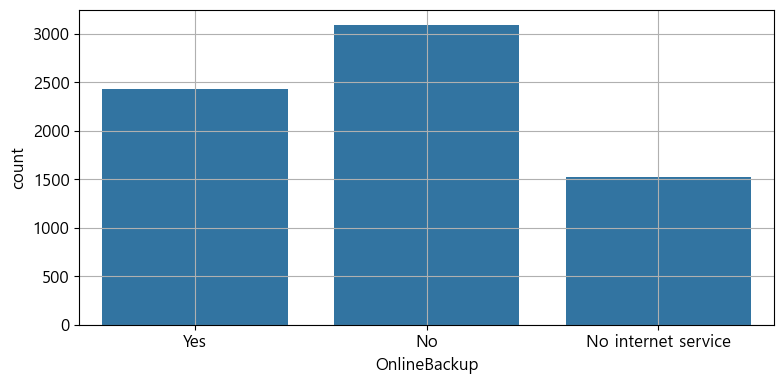

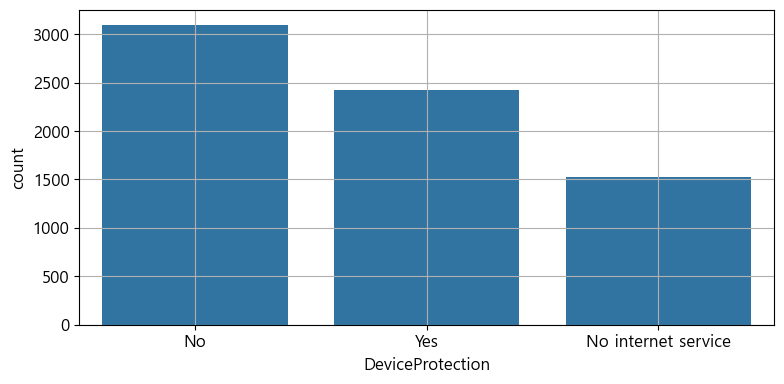

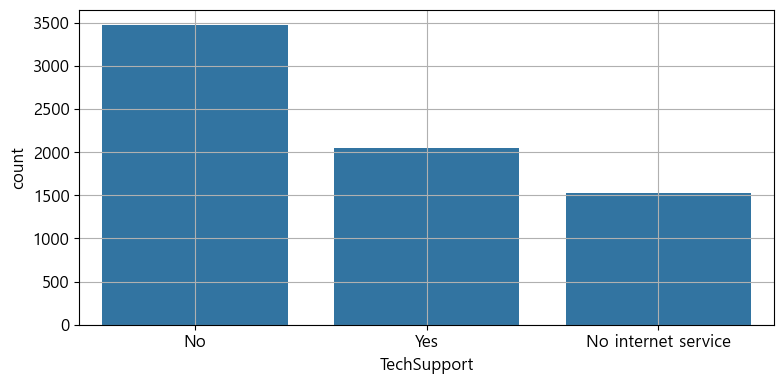

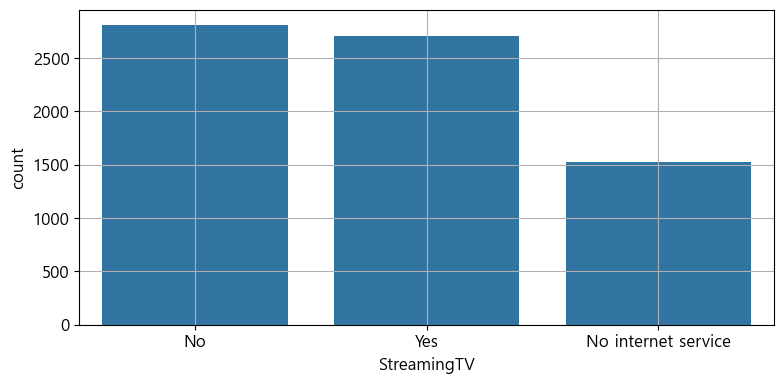

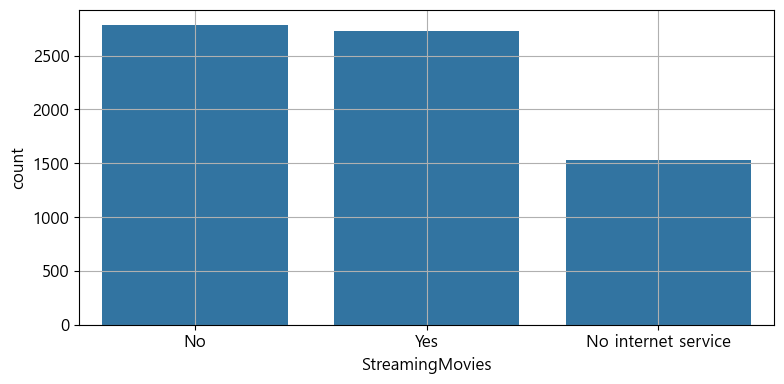

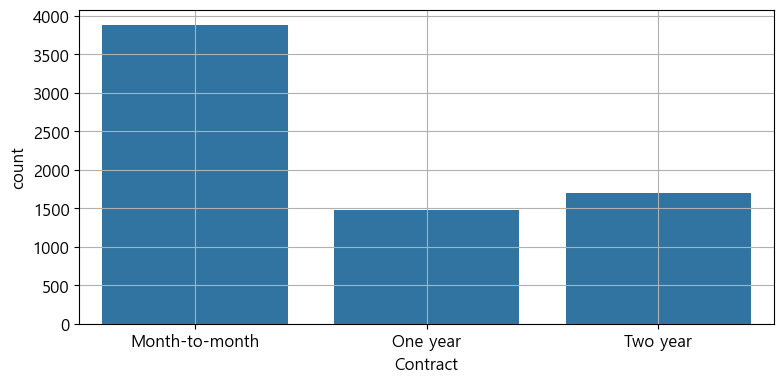

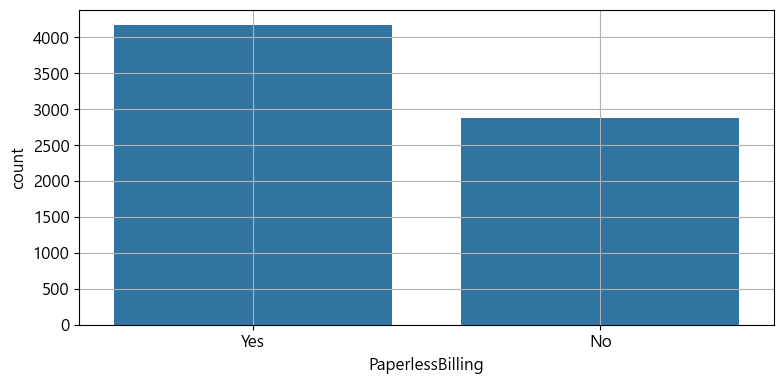

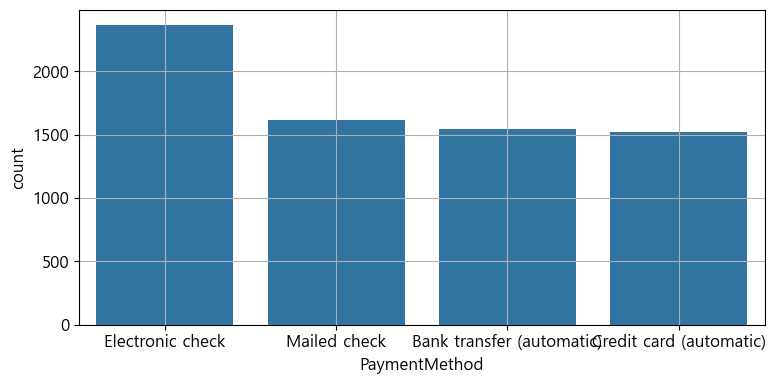

In [17]:
for i in col_o:
    my_countplot(df, xname = i, figsize = (8, 4))

- 연속형 / 범주형 데이터 컬럼의 종속변수별 데이터 분포 확인

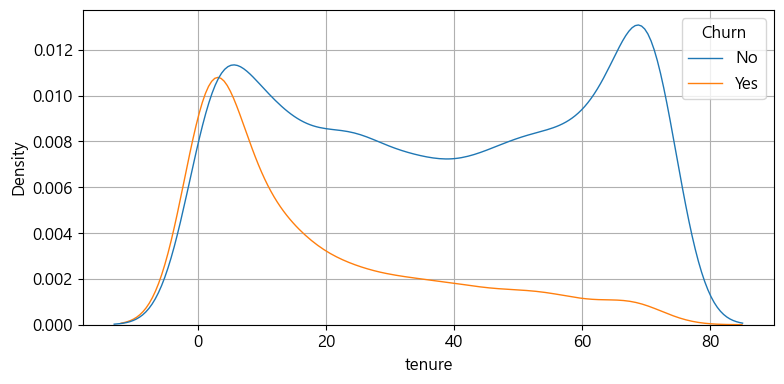

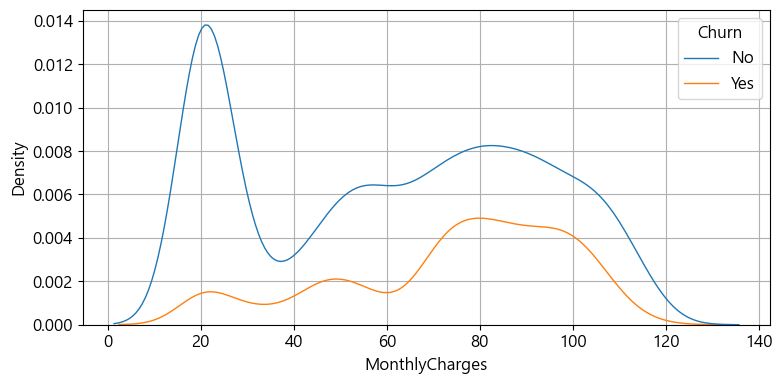

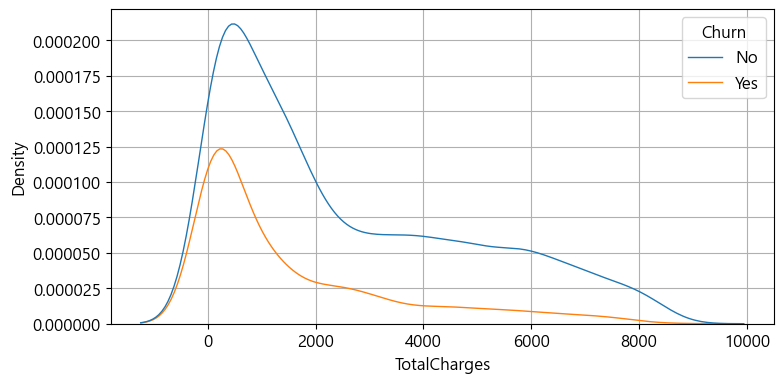

In [18]:
for x in col_n:
    my_kdeplot(df, xname = x, hue = 'Churn', figsize = (8, 4))

- tenure (가입기간) : 값이 클수록 No의 비중이 높아짐, 오랫동안 가입을 유지한 고객의 이탈율이 낮았음
- MonthlyCharges(월 청구 금액) : 값이 작을경우 No의 비중이 높아짐, 저렴한 요금제를 사용한 고객의 이탈율이 낮음
- TotalCharges(총 청구 금액) : 값의 분포별로 Yes-No의 비율은 비슷한 편

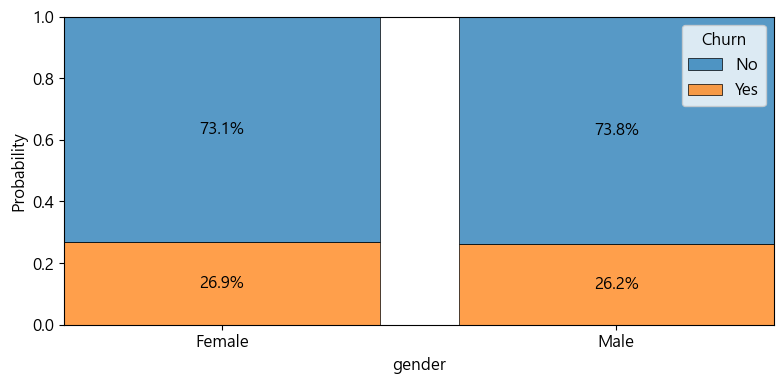

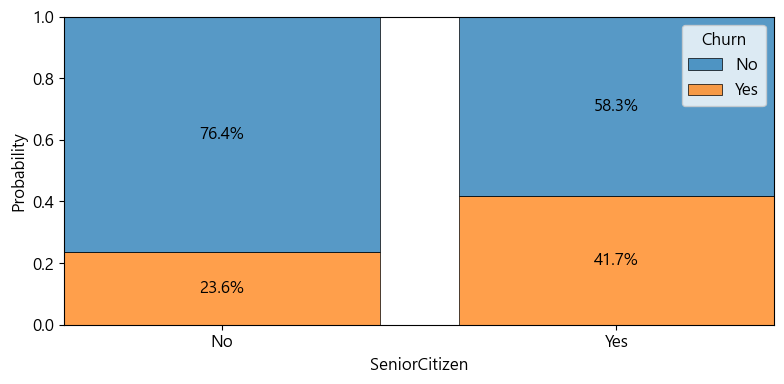

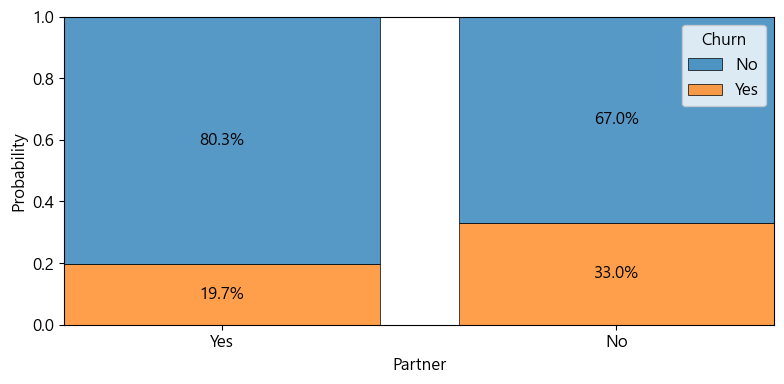

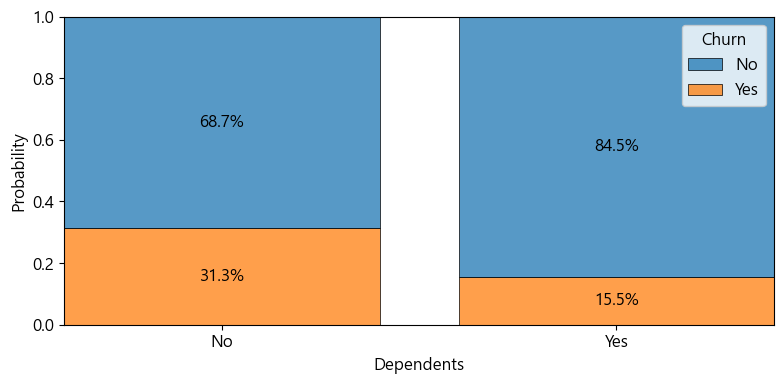

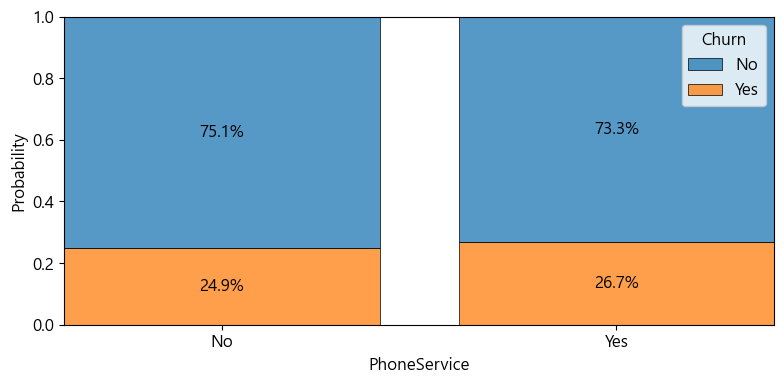

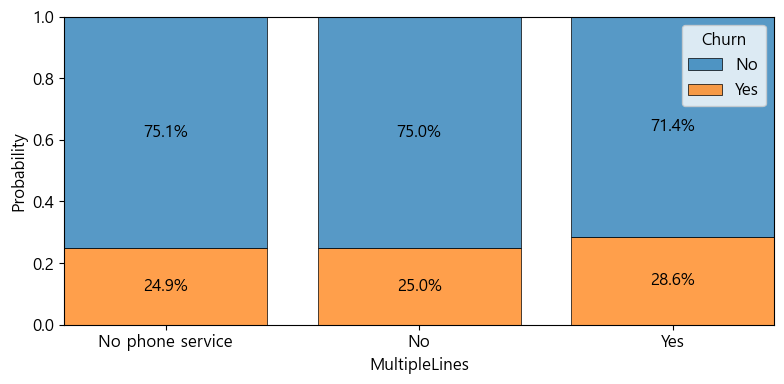

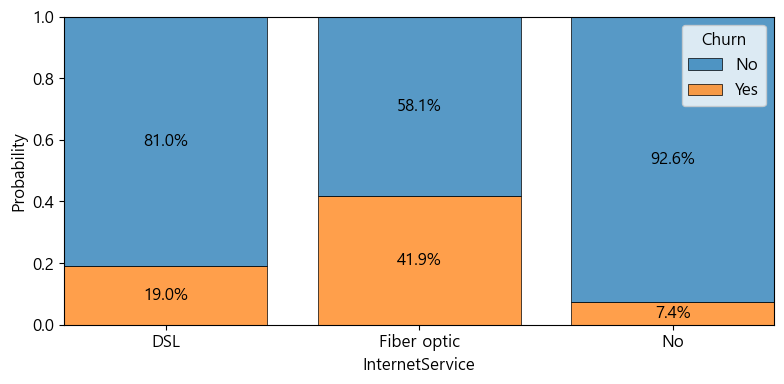

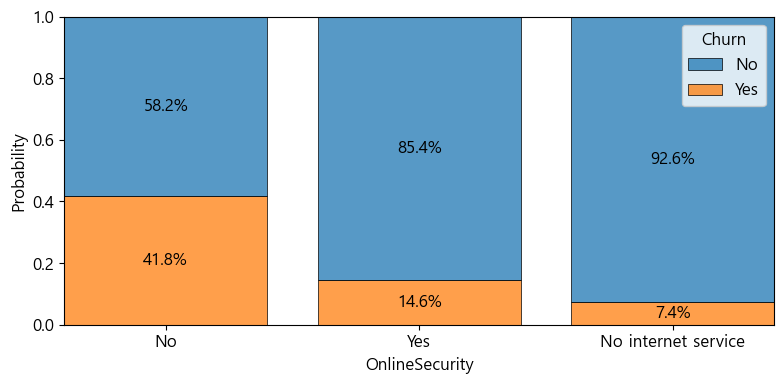

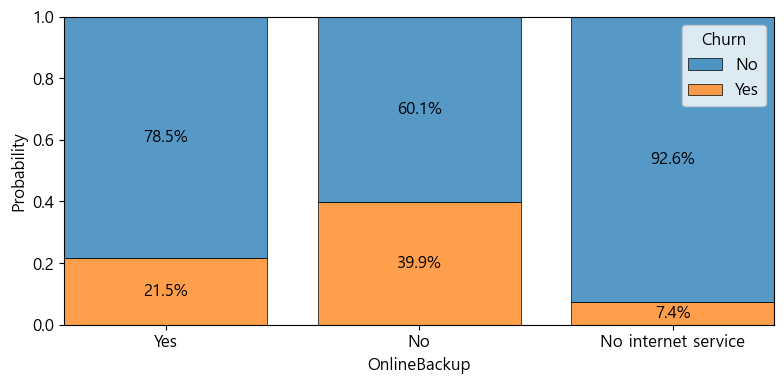

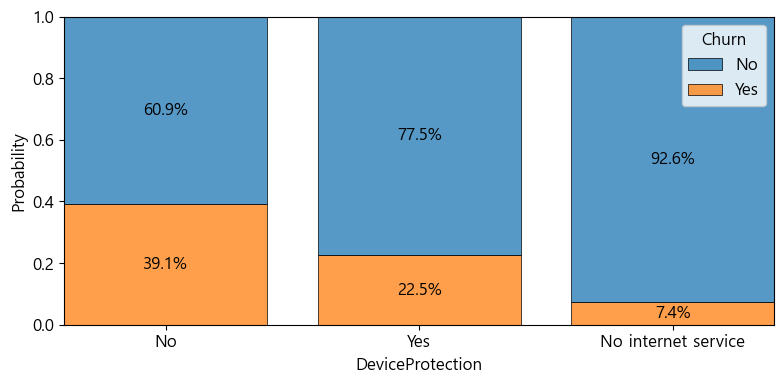

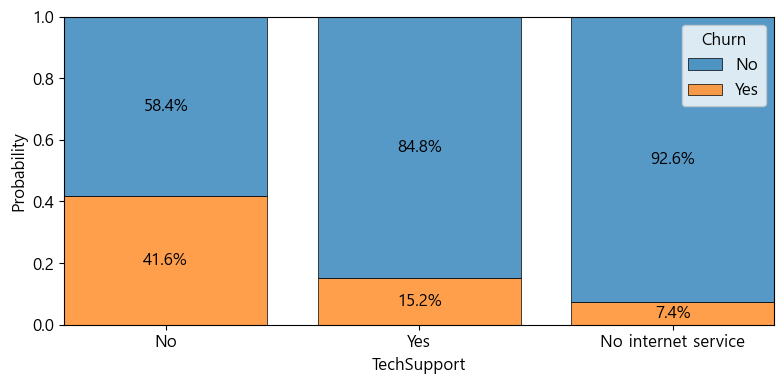

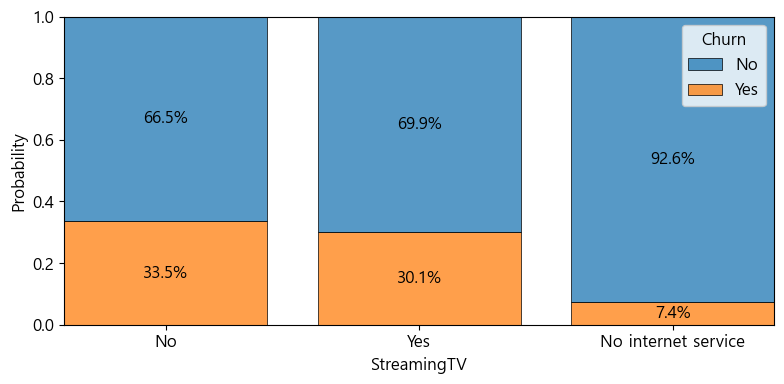

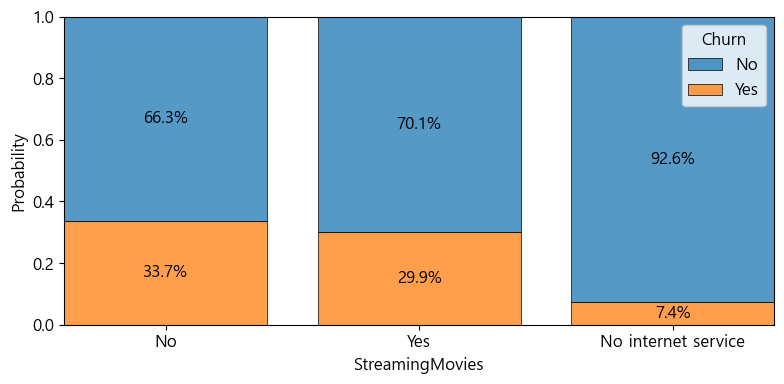

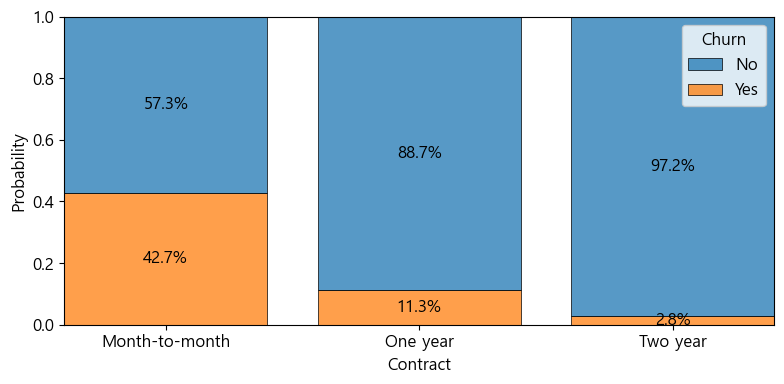

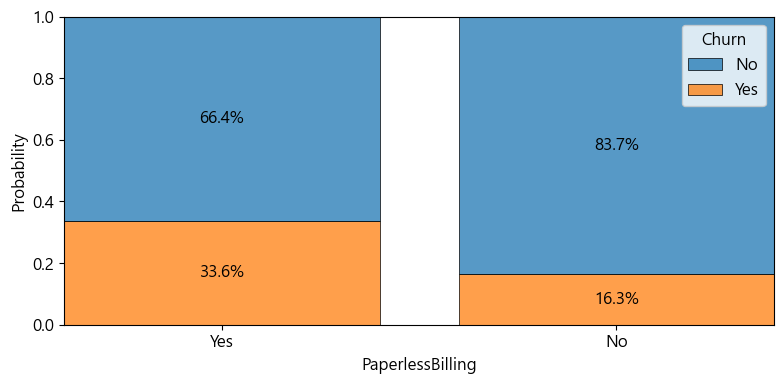

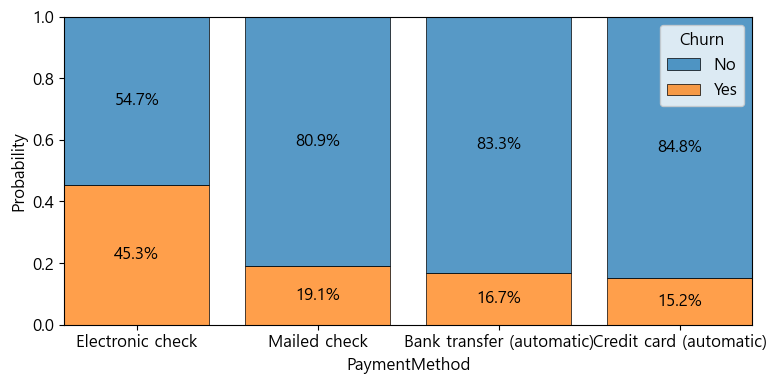

In [19]:
for x in col_o:
    my_stackplot(df, xname = x, hue = 'Churn', figsize = (8, 4))

- 성별과 같이 고객이탈에 영향을 거의 주지 않는 요소도 있고 보안 관련 사항같이 영향을 주는 요소도 있음

- 영향이 없는 변수간 교효작용 여부 확인

In [20]:
col_o_minor = ['gender', 'PhoneService', 'MultipleLines']

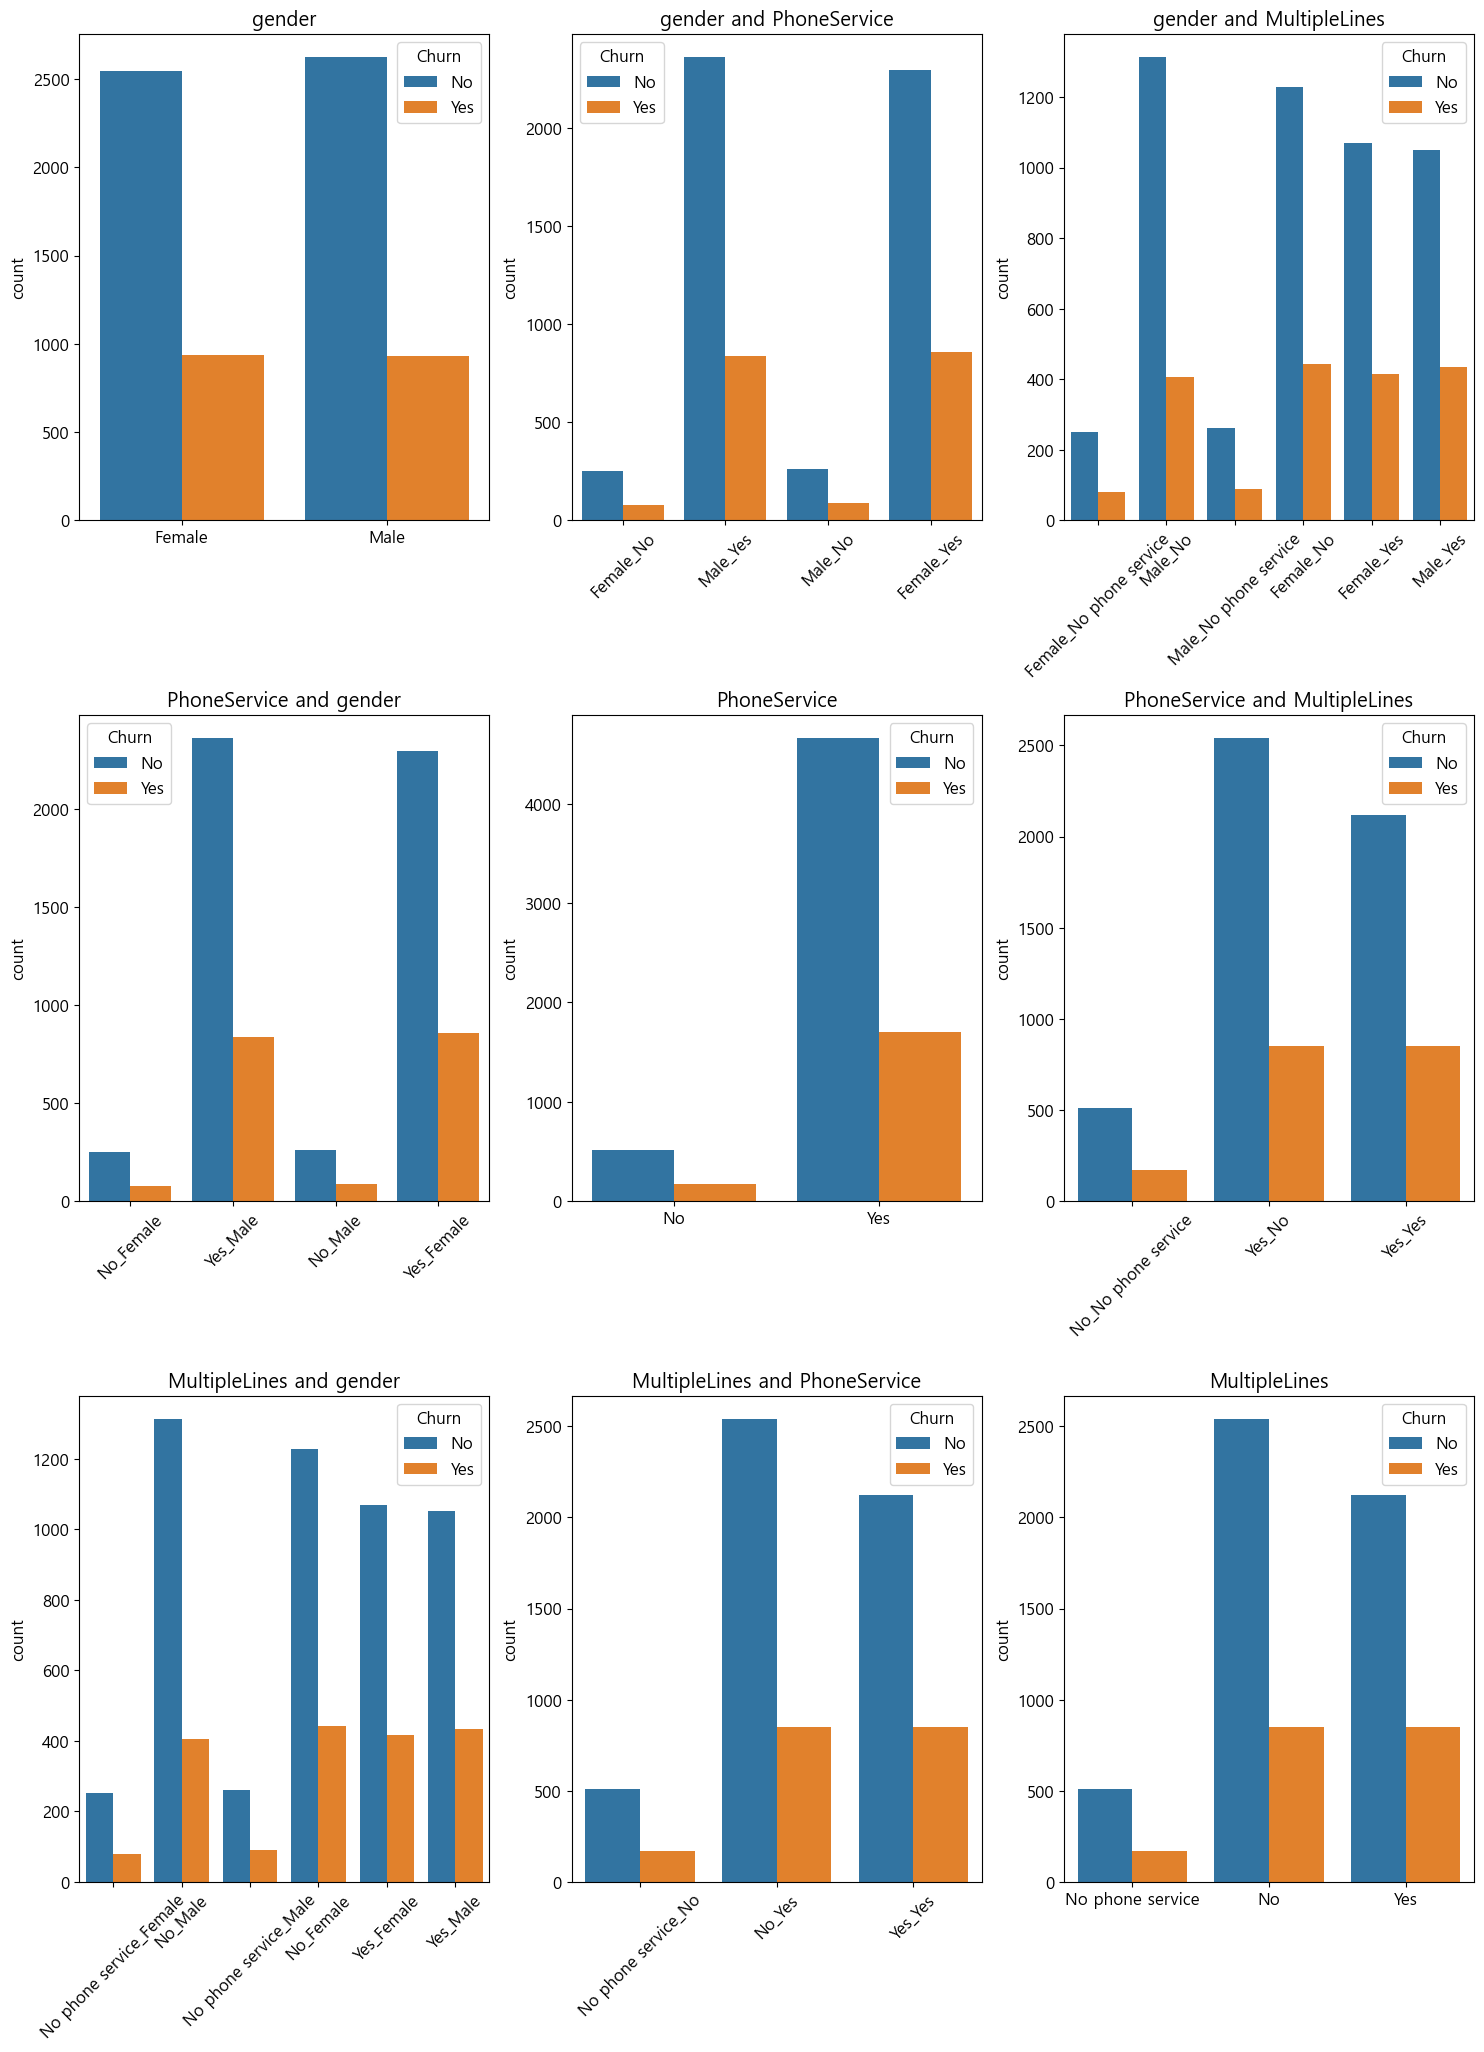

In [21]:
fig, ax = plt.subplots(len(col_o_minor), len(col_o_minor), figsize = (18, 24))
fig.subplots_adjust(hspace = 0.4)

for i, v in enumerate(col_o_minor):
    for j, w in enumerate(col_o_minor):
        if i == j:
            sb.countplot(data = df, x = v, hue = 'Churn', ax = ax[i, j])
            ax[i, j].set_title(v)
            ax[i, j].set_xlabel("")
        else:
            tmp = df[[v, w, 'Churn']]
            tmp['Combined'] = tmp[v] + "_" + tmp[w]
            sb.countplot(data = tmp, x = 'Combined', hue = 'Churn', ax = ax[i, j])
            ax[i, j].set_xticks(range(0, len(tmp['Combined'].unique())), tmp['Combined'].unique(), rotation = 45)
            ax[i, j].set_title(f"{v} and {w}")
            ax[i, j].set_xlabel("")
plt.show()

- 산점도 행렬

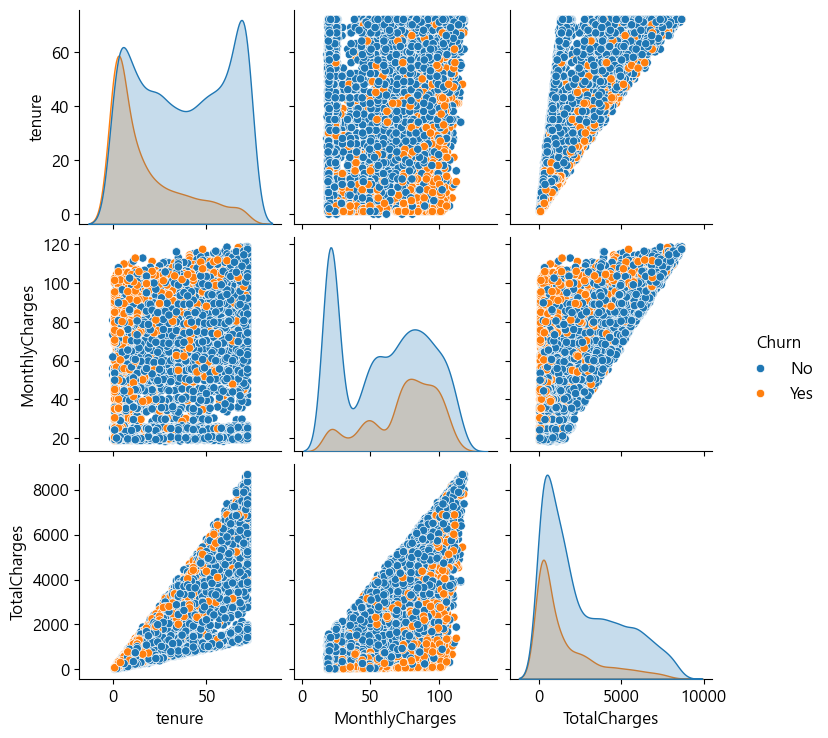

In [22]:
sb.pairplot(df, hue = 'Churn')
plt.show()

## 전처리 없이 모델 생성 및 성능 확인
- 결측치는 11개이므로 갯수가 많지 않아 삭제

In [23]:
pp_pre = YjkPreprocessor()
pp_pre.set_strategy(outline = None, null = 'd')

아래와 같이 처리합니다.
+-------------+----------------+
| 범주        | 처리방법       |
|-------------+----------------|
| 이상치 처리 | 처리하지 않음  |
| 결측치 처리 | 결측치 삭제    |
| 스케일러    | StandardScaler |
| 인코딩      | 원핫인코딩     |
+-------------+----------------+


In [24]:
df_pre = pp_pre.fit_transform(df, yname = 'Churn', ylabeling = True)

데이터프레임 크기 : (7043, 20)

[열별 결측치 개수]
+--------------+-------------+
| 열명         |   결측치 수 |
|--------------+-------------|
| TotalCharges |          11 |
+--------------+-------------+

연속형 데이터 컬럼 : ['tenure', 'MonthlyCharges', 'TotalCharges'], 총 3개
명목형 데이터 컬럼 : ['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod'], 총 16개
종속변수 컬럼명 : Churn / 종속변수 라벨링 여부 : True


In [25]:
X = df_pre.drop('Churn', axis = 1)
Y = df_pre['Churn']

x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state = 0, test_size = 0.2, stratify = Y)

In [26]:
results = []

def add_result(model, note, x_test, y_test):
    global results
    tmp_dict = {}
    tmp_dict['How'] = note
    tmp_dict['Accuracy'] = model.score(x_test, y_test)
    tmp_dict['Precision'] = precision_score(y_test, model.predict(x_test))
    tmp_dict['ROC_AUC'] = roc_auc_score(y_test, model.predict_proba(x_test)[:, 1])
    tmp_dict['model'] = model
    results.append(tmp_dict)

[교차검증]
+----+-------+-----------+-------------------+
|    |     C | penalty   |   mean_test_score |
|----+-------+-----------+-------------------|
|  7 |   0.1 | l2        |          0.802667 |
| 10 |     1 | l2        |          0.802311 |
| 13 |    10 | l2        |          0.801778 |
| 16 |   100 | l2        |          0.801778 |
|  4 |  0.01 | l2        |          0.800178 |
|  1 | 0.001 | l2        |          0.775644 |
+----+-------+-----------+-------------------+

[분류분석 성능평가]
+-------------------------+--------------+--------------+-----------------------------------------------------------+
|                         |   훈련데이터 |   검증데이터 | 설명                                                      |
|-------------------------+--------------+--------------+-----------------------------------------------------------|
| 의사결정계수(Pseudo R2) |     0.280439 |     0.291586 | 로지스틱회귀의 성능 측정 지표로, 1에 가까울수록 좋은 모델 |
| 정확도(Accuracy)        |     0.803556 |     0.813788 | 예측 결과(TN,FP,TP,TN)가 실제 결과

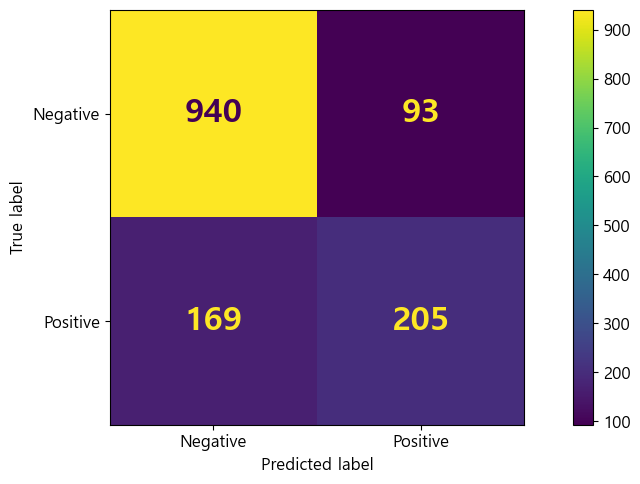


[학습곡선]


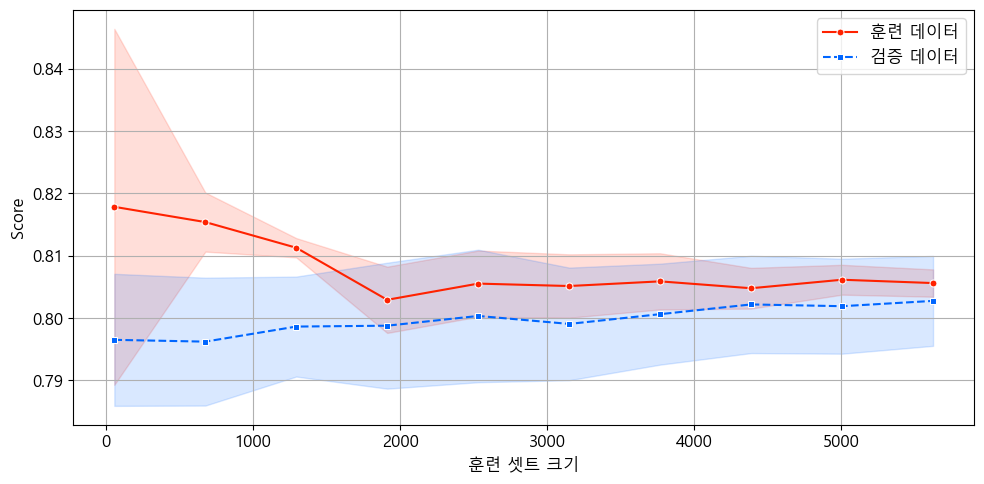

In [27]:
model = my_logistic_classification(x_train, y_train, x_test, y_test, report = False)
add_result(model, '원본 데이터', x_test, y_test)

- 전반적으로 양성(이탈 고객)을 맞추는 비율이 낮음 (정밀도 66%)
- 학습 곡선 상으로는 특별한 과적합 양상은 보이지 않음

## 피처 엔지니어링

### Binning

In [28]:
df2 = df.copy()
df2.dropna(inplace = True)

- 연속형 변수별로 적합한 구간을 나누어 파생변수로 명목형 변수 생성

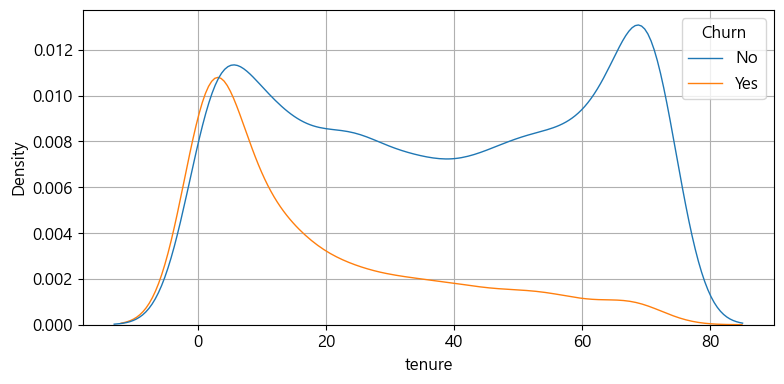

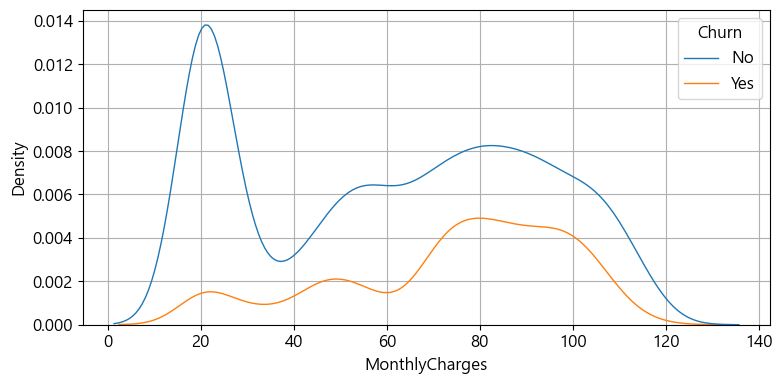

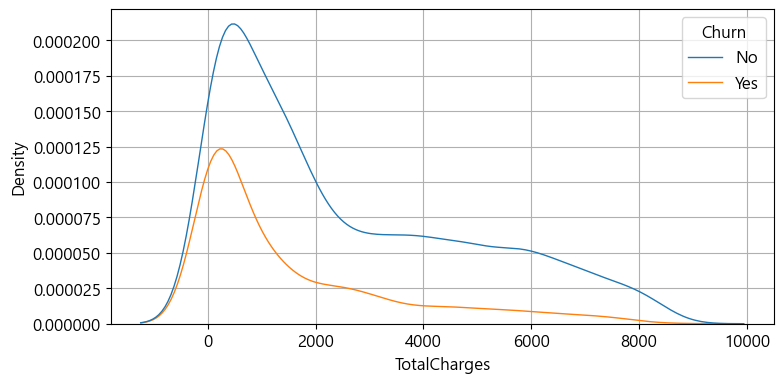

In [29]:
for x in col_n:
    my_kdeplot(df, xname = x, hue = 'Churn', figsize = (8, 4))

- tenure : 40, MonthlyCharges : 35 / 60, TotalCharges : 2000 기준으로 데이터를 분할하여 Binning 진행

In [30]:
df2['tenure_bin'] = df2['tenure'].apply(lambda x : 0 if x < 40 else 1)
df2['MonthlyCharges_bin'] = df2['MonthlyCharges'].apply(lambda x : 0 if x < 35 else (1 if x < 60 else 2))
df2['TotalCharges_bin'] = df2['tenure'].apply(lambda x : 0 if x < 2000 else 1)

df2['tenure_bin'] = df2['tenure_bin'].astype('category')
df2['MonthlyCharges_bin'] = df2['MonthlyCharges_bin'].astype('category')
df2['TotalCharges_bin'] = df2['MonthlyCharges_bin'].astype('category')

In [31]:
pp = YjkPreprocessor()
pp.set_strategy(outline = None, null = 'd')

아래와 같이 처리합니다.
+-------------+----------------+
| 범주        | 처리방법       |
|-------------+----------------|
| 이상치 처리 | 처리하지 않음  |
| 결측치 처리 | 결측치 삭제    |
| 스케일러    | StandardScaler |
| 인코딩      | 원핫인코딩     |
+-------------+----------------+


In [32]:
df2_p = pp.fit_transform(df2, yname = 'Churn', ylabeling = True)
X = df2_p.drop('Churn', axis = 1)
Y = df2_p['Churn']

데이터프레임 크기 : (7032, 23)
데이터프레임에 결측치는 없습니다.
연속형 데이터 컬럼 : ['tenure', 'MonthlyCharges', 'TotalCharges'], 총 3개
명목형 데이터 컬럼 : ['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'tenure_bin', 'MonthlyCharges_bin', 'TotalCharges_bin'], 총 19개
종속변수 컬럼명 : Churn / 종속변수 라벨링 여부 : True


[교차검증]
+----+-------+-----------+-------------------+
|    |     C | penalty   |   mean_test_score |
|----+-------+-----------+-------------------|
|  7 |   0.1 | l2        |          0.805333 |
| 10 |     1 | l2        |          0.804267 |
| 16 |   100 | l2        |          0.803911 |
| 13 |    10 | l2        |          0.803733 |
|  4 |  0.01 | l2        |          0.800356 |
|  1 | 0.001 | l2        |          0.779733 |
+----+-------+-----------+-------------------+

[분류분석 성능평가]
+-------------------------+--------------+--------------+-----------------------------------------------------------+
|                         |   훈련데이터 |   검증데이터 | 설명                                                      |
|-------------------------+--------------+--------------+-----------------------------------------------------------|
| 의사결정계수(Pseudo R2) |     0.284229 |     0.295358 | 로지스틱회귀의 성능 측정 지표로, 1에 가까울수록 좋은 모델 |
| 정확도(Accuracy)        |     0.806222 |      0.81592 | 예측 결과(TN,FP,TP,TN)가 실제 결과

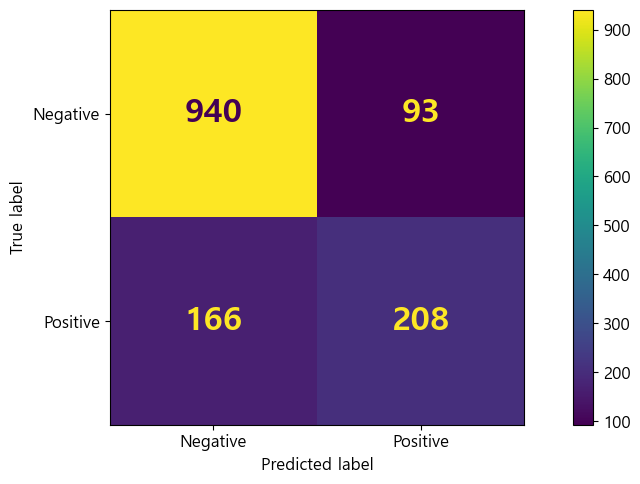


[학습곡선]


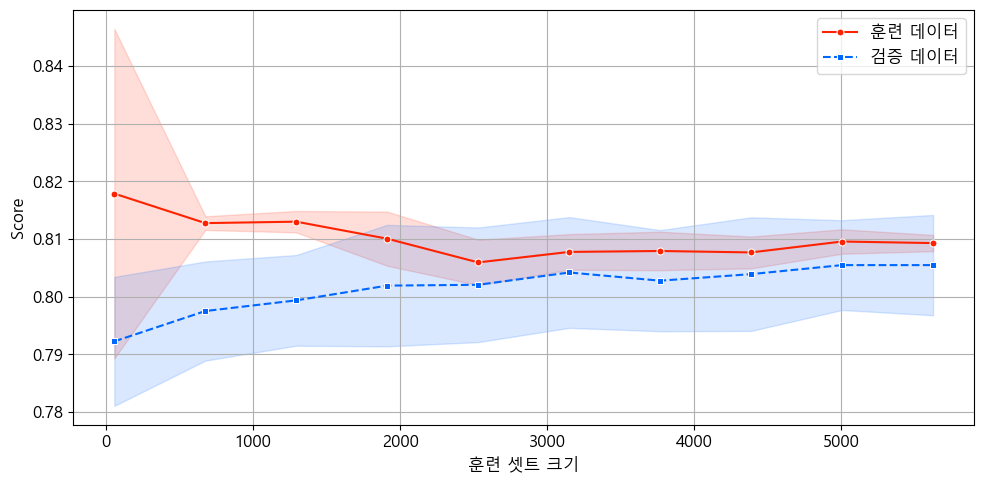

In [33]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state = 0, test_size = 0.2, stratify = Y)
model = my_logistic_classification(x_train, y_train, x_test, y_test, report = False)
add_result(model, 'Binning', x_test, y_test)

## 오버 / 언더샘플링

### 언더샘플링

In [34]:
from imblearn.under_sampling import RandomUnderSampler

In [35]:
undersampler = RandomUnderSampler(sampling_strategy = 'majority', random_state = 0)
x_under, y_under = undersampler.fit_resample(x_train, y_train)
x_under.shape, y_under.shape

((2990, 54), (2990,))

In [36]:
y_under.value_counts()

0    1495
1    1495
Name: Churn, dtype: int64

[교차검증]
+----+-------+-----------+-------------------+
|    |     C | penalty   |   mean_test_score |
|----+-------+-----------+-------------------|
| 10 |     1 | l2        |          0.766221 |
|  7 |   0.1 | l2        |          0.764883 |
| 13 |    10 | l2        |          0.763545 |
|  4 |  0.01 | l2        |          0.761873 |
| 16 |   100 | l2        |          0.761538 |
|  1 | 0.001 | l2        |          0.752508 |
+----+-------+-----------+-------------------+

[분류분석 성능평가]
+-------------------------+--------------+--------------+-----------------------------------------------------------+
|                         |   훈련데이터 |   검증데이터 | 설명                                                      |
|-------------------------+--------------+--------------+-----------------------------------------------------------|
| 의사결정계수(Pseudo R2) |     0.308794 |     0.168701 | 로지스틱회귀의 성능 측정 지표로, 1에 가까울수록 좋은 모델 |
| 정확도(Accuracy)        |     0.773244 |     0.752665 | 예측 결과(TN,FP,TP,TN)가 실제 결과

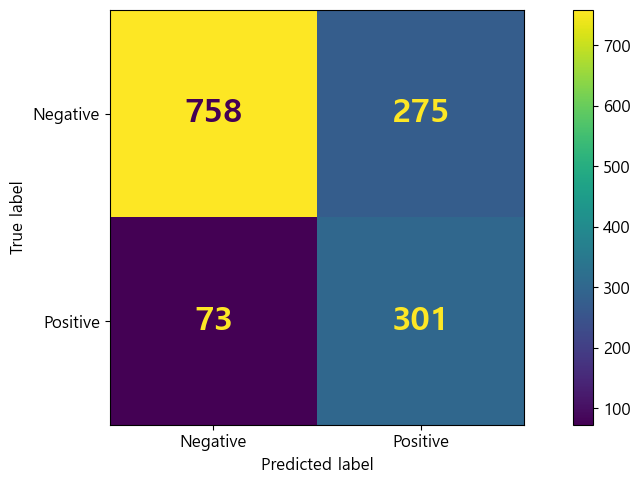


[학습곡선]


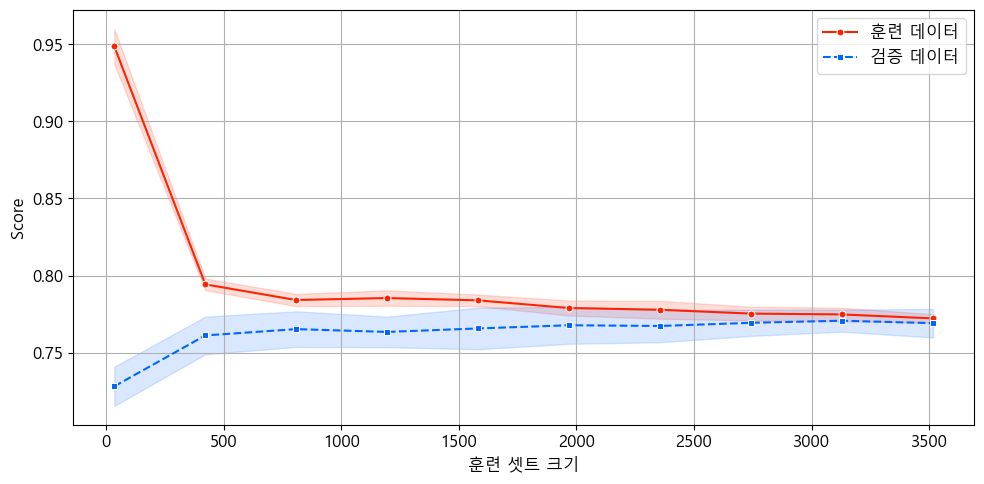

In [37]:
model = my_logistic_classification(x_under, y_under, x_test, y_test, report = False)
add_result(model, '언더샘플링', x_test, y_test)

### 오버샘플링

In [38]:
from imblearn.over_sampling import RandomOverSampler

In [39]:
oversampler = RandomOverSampler(sampling_strategy = 'minority', random_state = 0)
x_over, y_over = oversampler.fit_resample(x_train, y_train)
x_over.shape, y_over.shape

((8260, 54), (8260,))

In [40]:
y_over.value_counts()

0    4130
1    4130
Name: Churn, dtype: int64

[교차검증]
+----+-------+-----------+-------------------+
|    |     C | penalty   |   mean_test_score |
|----+-------+-----------+-------------------|
|  7 |   0.1 | l2        |          0.765012 |
|  4 |  0.01 | l2        |          0.764165 |
| 10 |     1 | l2        |          0.764165 |
| 13 |    10 | l2        |          0.764044 |
| 16 |   100 | l2        |          0.763923 |
|  1 | 0.001 | l2        |          0.752906 |
+----+-------+-----------+-------------------+

[분류분석 성능평가]
+-------------------------+--------------+--------------+-----------------------------------------------------------+
|                         |   훈련데이터 |   검증데이터 | 설명                                                      |
|-------------------------+--------------+--------------+-----------------------------------------------------------|
| 의사결정계수(Pseudo R2) |     0.301826 |     0.176618 | 로지스틱회귀의 성능 측정 지표로, 1에 가까울수록 좋은 모델 |
| 정확도(Accuracy)        |     0.765738 |     0.750533 | 예측 결과(TN,FP,TP,TN)가 실제 결과

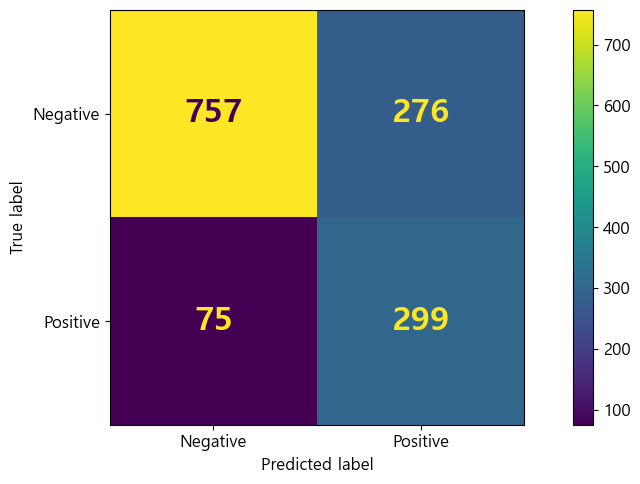


[학습곡선]


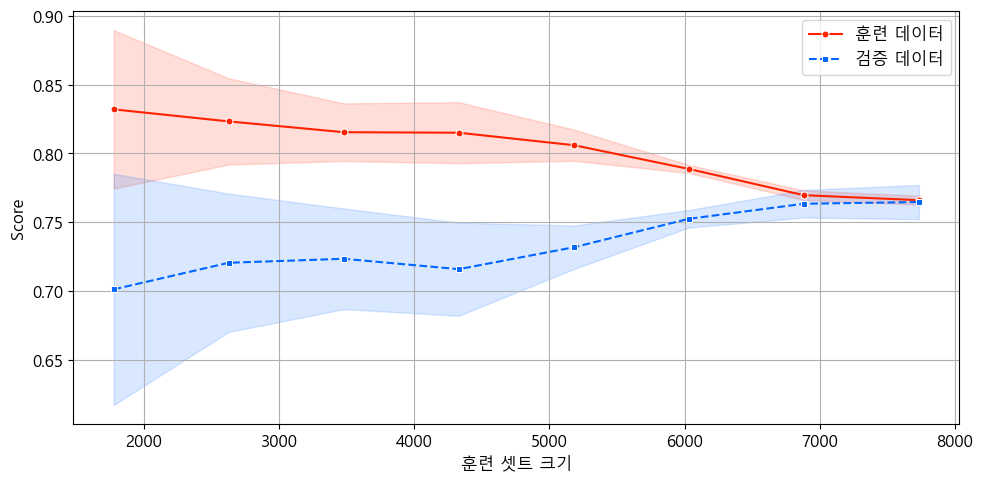

In [41]:
model = my_logistic_classification(x_over, y_over, x_test, y_test, report = False)
add_result(model, '오버샘플링', x_test, y_test)

## SMOTE

In [42]:
from imblearn.over_sampling import SMOTE

In [43]:
smote = SMOTE(sampling_strategy = 'minority', k_neighbors = 3, random_state = 0)
x_smote, y_smote = smote.fit_resample(X = x_train, y = y_train)
x_smote.shape, y_smote.shape

((8260, 54), (8260,))

In [44]:
y_smote.value_counts()

0    4130
1    4130
Name: Churn, dtype: int64

[교차검증]
+----+-------+-----------+-------------------+
|    |     C | penalty   |   mean_test_score |
|----+-------+-----------+-------------------|
|  7 |   0.1 | l2        |          0.765012 |
|  4 |  0.01 | l2        |          0.764165 |
| 10 |     1 | l2        |          0.764165 |
| 13 |    10 | l2        |          0.764044 |
| 16 |   100 | l2        |          0.763923 |
|  1 | 0.001 | l2        |          0.752906 |
+----+-------+-----------+-------------------+

[분류분석 성능평가]
+-------------------------+--------------+--------------+-----------------------------------------------------------+
|                         |   훈련데이터 |   검증데이터 | 설명                                                      |
|-------------------------+--------------+--------------+-----------------------------------------------------------|
| 의사결정계수(Pseudo R2) |     0.301826 |     0.176618 | 로지스틱회귀의 성능 측정 지표로, 1에 가까울수록 좋은 모델 |
| 정확도(Accuracy)        |     0.765738 |     0.750533 | 예측 결과(TN,FP,TP,TN)가 실제 결과

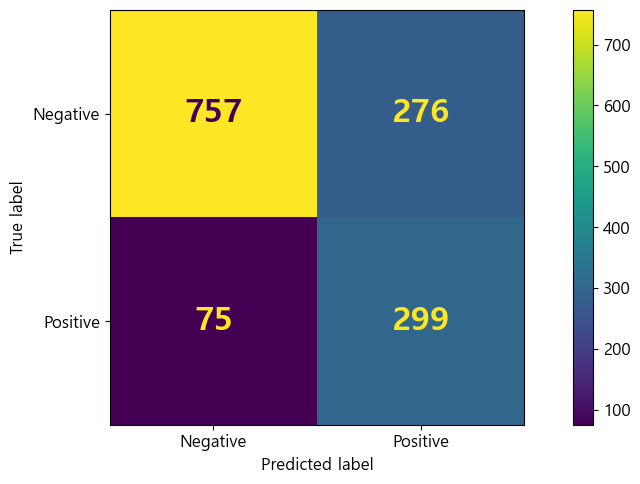


[학습곡선]


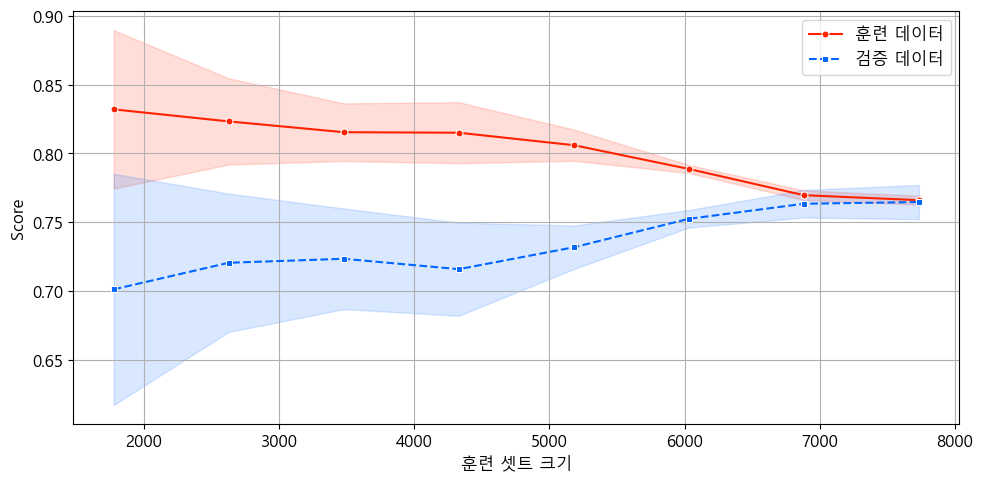

In [45]:
model = my_logistic_classification(x_over, y_over, x_test, y_test, report = False)
add_result(model, 'SMOTE', x_test, y_test)

In [46]:
pd.DataFrame(results)

,How,Accuracy,Precision,ROC_AUC,model
0,원본 데이터,0.813788,0.687919,0.851370,"LogisticRegression(C=0.1, max_iter=500, n_jobs..."
1,Binning,0.815920,0.691030,0.853239,"LogisticRegression(C=0.1, max_iter=500, n_jobs..."
2,언더샘플링,0.752665,0.522569,0.851663,"LogisticRegression(C=1, max_iter=500, n_jobs=-1)"
3,오버샘플링,0.750533,0.520000,0.853736,"LogisticRegression(C=0.1, max_iter=500, n_jobs..."
4,SMOTE,0.750533,0.520000,0.853736,"LogisticRegression(C=0.1, max_iter=500, n_jobs..."


In [47]:
model_us = results[2]['model']
model_us

LogisticRegression(C=1, max_iter=500, n_jobs=-1)

In [48]:
test_df = df2.loc[y_test.index]

In [49]:
test_df['predict'] = model_us.predict(x_test)

In [50]:
test_df['predict'] = test_df['predict'].map({0 : "No", 1 : "Yes"})
test_df['Correct'] = test_df['predict'] == test_df['Churn']

In [51]:
test_df.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,...,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,tenure_bin,MonthlyCharges_bin,TotalCharges_bin,predict,Correct
5134,Male,Yes,No,No,15,Yes,Yes,Fiber optic,No,Yes,...,Yes,Electronic check,80.20,1217.25,Yes,0,2,2,Yes,True
2428,Male,No,No,Yes,38,Yes,Yes,Fiber optic,No,No,...,Yes,Bank transfer (automatic),99.25,3777.15,Yes,0,2,2,Yes,True
2503,Male,No,Yes,Yes,44,Yes,No,No,No internet service,No internet service,...,No,Bank transfer (automatic),20.60,926.00,No,1,0,0,No,True
3119,Female,Yes,Yes,No,32,Yes,Yes,Fiber optic,No,No,...,Yes,Credit card (automatic),85.95,2628.60,Yes,0,2,2,Yes,True
2534,Male,No,Yes,No,69,Yes,Yes,Fiber optic,Yes,Yes,...,Yes,Credit card (automatic),107.20,7317.10,No,1,2,2,No,True


In [52]:
test_df_pre_yes = test_df[test_df['predict'] == 'Yes']

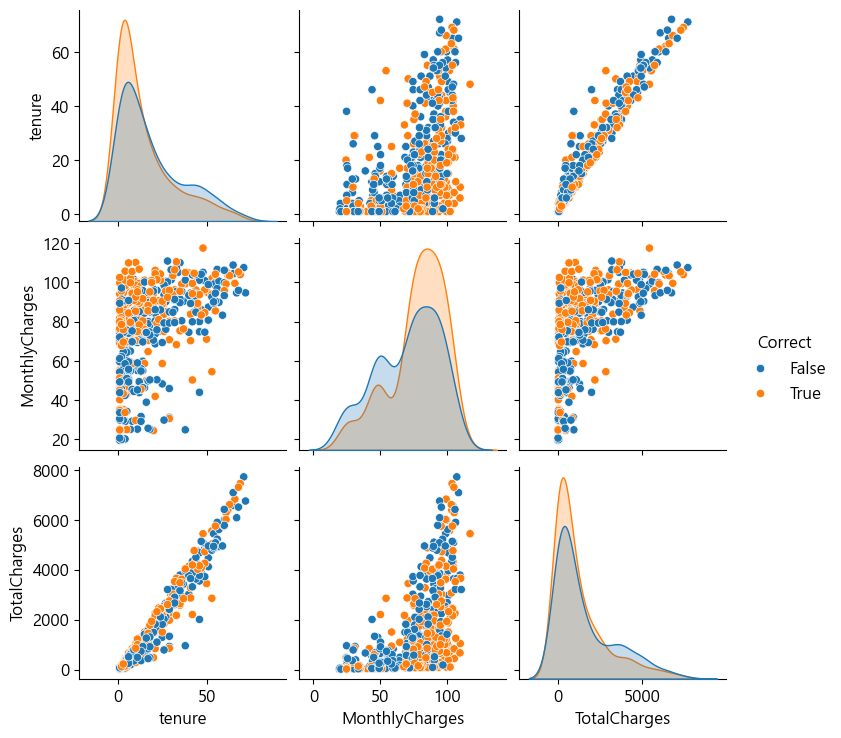

In [53]:
sb.pairplot(test_df_pre_yes, hue = 'Correct')
plt.show()

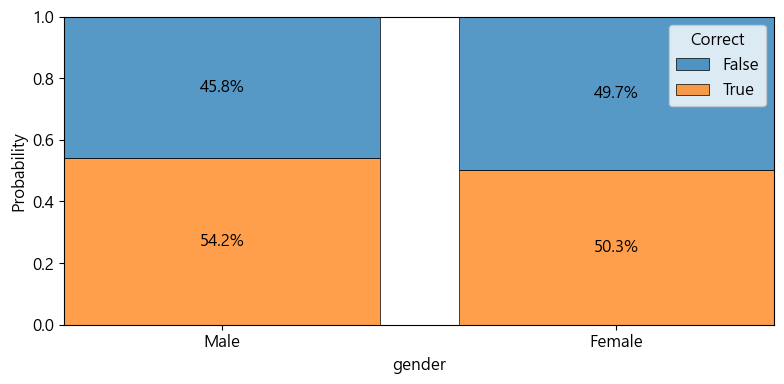

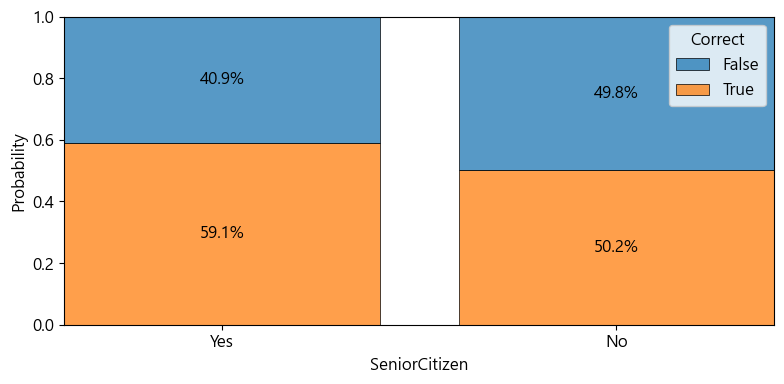

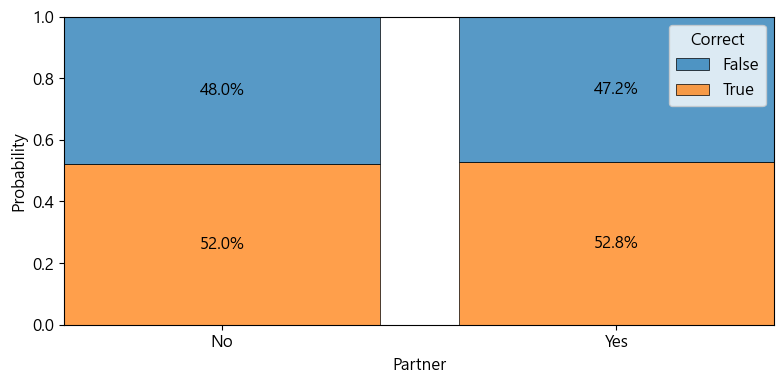

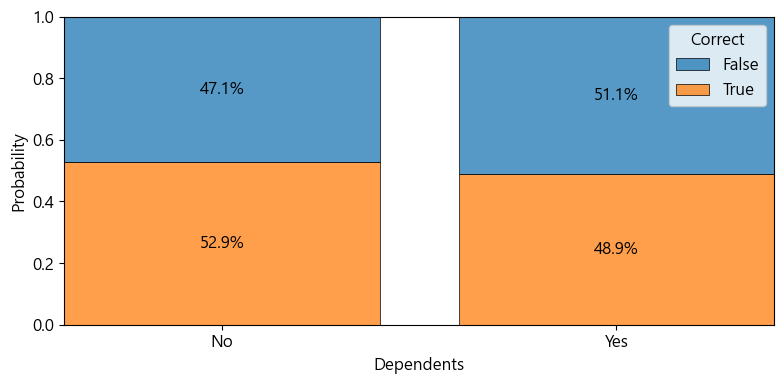

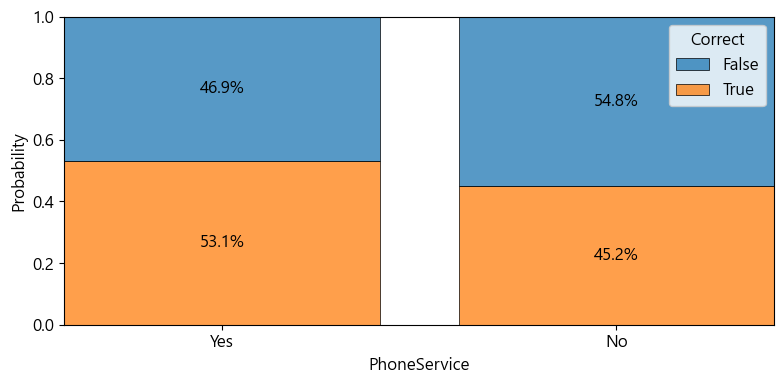

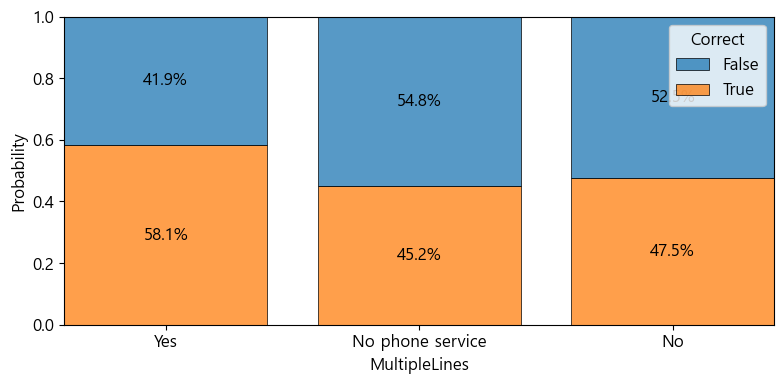

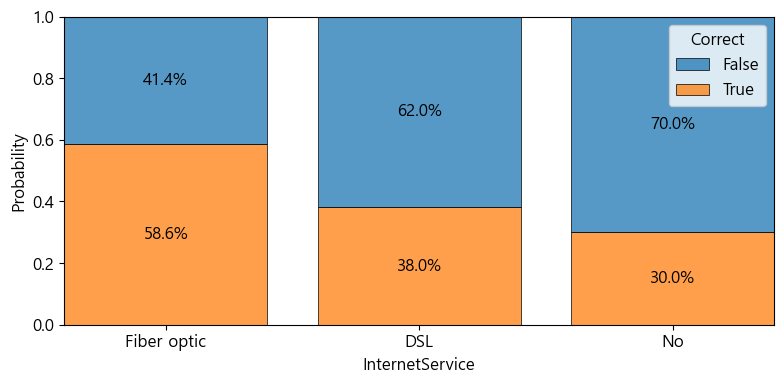

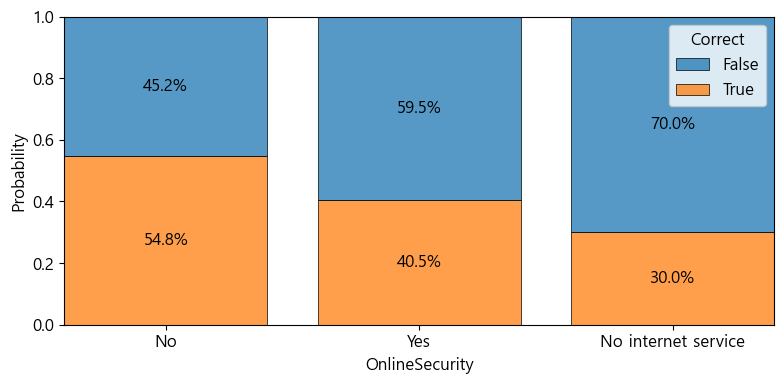

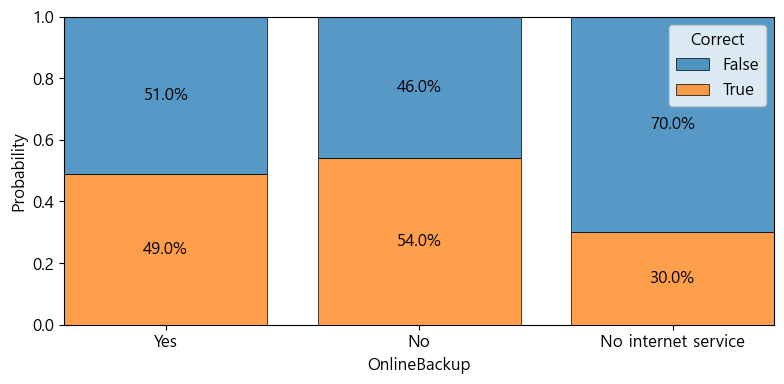

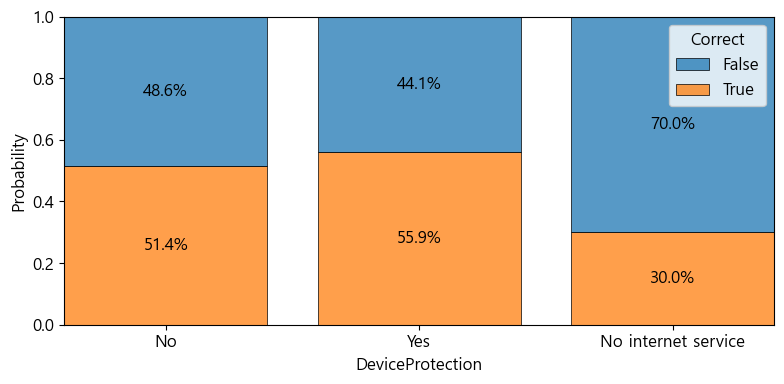

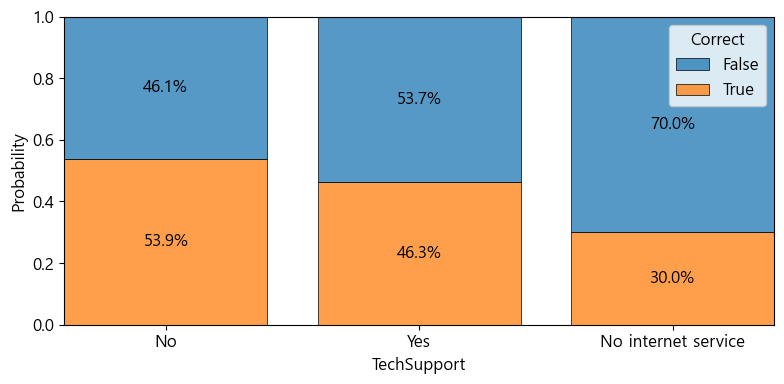

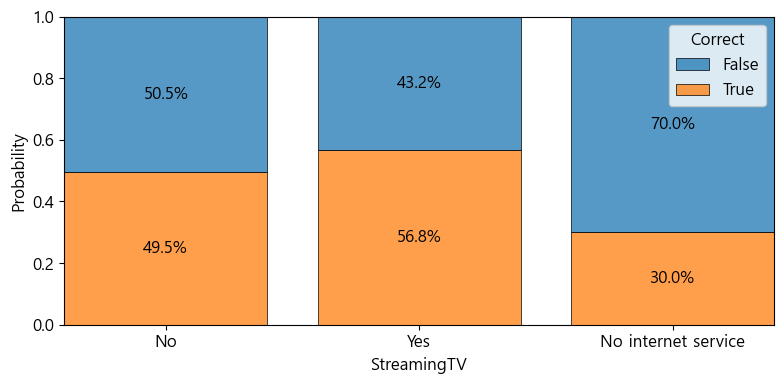

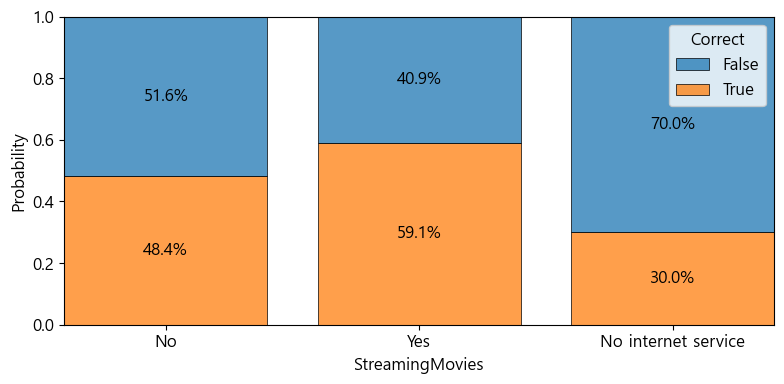

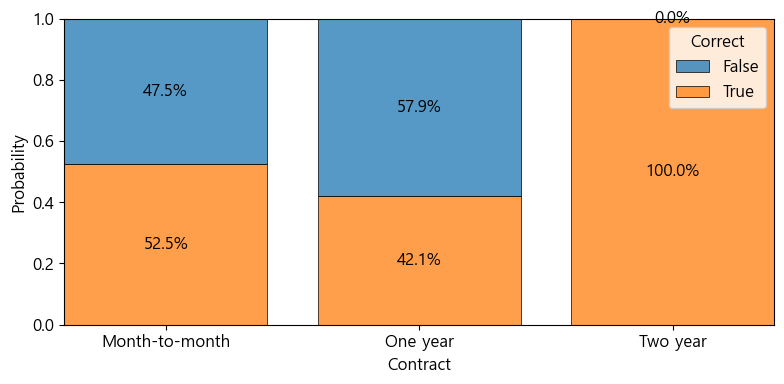

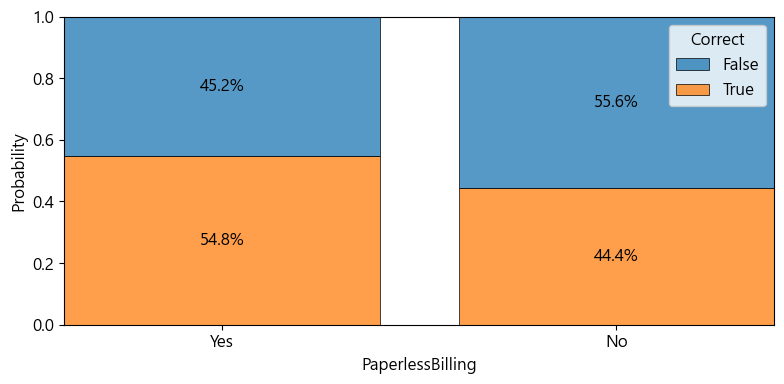

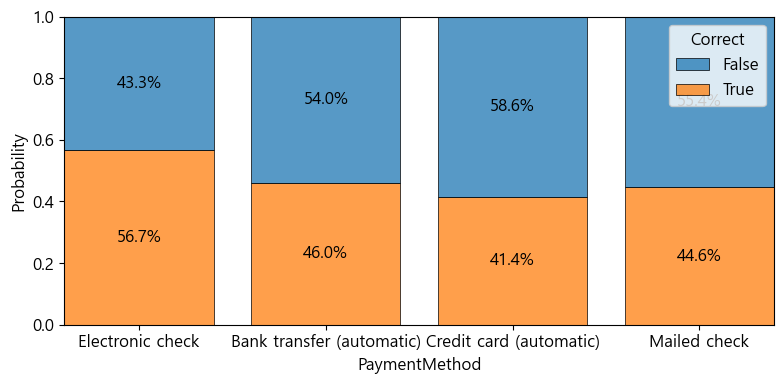

In [54]:
for x in col_o:
    my_stackplot(test_df_pre_yes, xname = x, hue = 'Correct', figsize = (8, 4))

In [55]:
for a, v in enumerate(col_o):
    for b in range(a+1, len(col_o)):
        w = col_o[b]
        if v == w:
            continue
        tmp = test_df_pre_yes[[v, w, 'Correct']]
        lv = len(tmp[v].unique())
        lw = len(tmp[w].unique())
        tmp_df = pd.DataFrame(np.zeros((lv, lw)), index = tmp[v].unique(), columns = tmp[w].unique(), dtype = 'object')

        for i in tmp_df.columns:
            for j in tmp_df.index:
                tmp_df.at[j, i] = [0, 0]

        print(f"['{v}', '{w}']")
        for k in tmp.index:
            if tmp.loc[k, 'Correct']:
                tmp_df.loc[tmp.loc[k, v], tmp.loc[k, w]][0] += 1
            else:
                tmp_df.loc[tmp.loc[k, v], tmp.loc[k, w]][1] += 1

        for i in tmp_df.columns:
            for j in tmp_df.index:
                try:
                    ratio = (tmp_df.at[j, i][0]) / (tmp_df.at[j, i][0] + tmp_df.at[j, i][1])
                    ratio = np.round(ratio, 2)
                except:
                    ratio = 0
                tmp_df.at[j, i].append(ratio)
        print(tabulate(tmp_df, headers = 'keys', tablefmt = 'psql', showindex = True, numalign = "right"), end = "\n\n")

['gender', 'SeniorCitizen']
+--------+----------------+------------------+
|        | Yes            | No               |
|--------+----------------+------------------|
| Male   | [36, 23, 0.61] | [118, 107, 0.52] |
| Female | [42, 31, 0.58] | [105, 114, 0.48] |
+--------+----------------+------------------+

['gender', 'Partner']
+--------+-----------------+----------------+
|        | No              | Yes            |
|--------+-----------------+----------------|
| Male   | [93, 86, 0.52]  | [61, 44, 0.58] |
| Female | [103, 95, 0.52] | [44, 50, 0.47] |
+--------+-----------------+----------------+

['gender', 'Dependents']
+--------+------------------+----------------+
|        | No               | Yes            |
|--------+------------------+----------------|
| Male   | [130, 110, 0.54] | [24, 20, 0.55] |
| Female | [126, 118, 0.52] | [21, 27, 0.44] |
+--------+------------------+----------------+

['gender', 'PhoneService']
+--------+------------------+----------------+
|       

In [56]:
combine_list = [['gender', 'SeniorCitizen'], ['gender', 'PhoneService'], ['gender', 'MultipleLines'], ['gender', 'InternetService'],
               ['gender', 'StreamingMovies'], ['gender', 'PaperlessBilling'], ['SeniorCitizen', 'MultipleLines'], ['SeniorCitizen', 'InternetService'],
               ['SeniorCitizen', 'OnlineSecurity'], ['SeniorCitizen', 'StreamingTV'], ['SeniorCitizen', 'PaymentMethod'], ['Partner', 'MultipleLines'],
               ['Partner', 'InternetService'], ['Partner', 'DeviceProtection'], ['Partner', 'PaperlessBilling'], ['Dependents', 'StreamingMovies'],
               ['Dependents', 'PaperlessBilling'], ['PhoneService', 'DeviceProtection'], ['PhoneService', 'StreamingTV']]

In [57]:
df3 = df2.copy()

In [58]:
for i, v in enumerate(combine_list):
    df3[f"comb_{i}"] = df3[v[0]] + "_" + df3[v[1]]

In [59]:
df3_p = pp.fit_transform(df3, yname = 'Churn', ylabeling = True)
X = df3_p.drop('Churn', axis = 1)
Y = df3_p['Churn']

데이터프레임 크기 : (7032, 42)
데이터프레임에 결측치는 없습니다.
연속형 데이터 컬럼 : ['tenure', 'MonthlyCharges', 'TotalCharges'], 총 3개
명목형 데이터 컬럼 : ['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'tenure_bin', 'MonthlyCharges_bin', 'TotalCharges_bin', 'comb_0', 'comb_1', 'comb_2', 'comb_3', 'comb_4', 'comb_5', 'comb_6', 'comb_7', 'comb_8', 'comb_9', 'comb_10', 'comb_11', 'comb_12', 'comb_13', 'comb_14', 'comb_15', 'comb_16', 'comb_17', 'comb_18'], 총 38개
종속변수 컬럼명 : Churn / 종속변수 라벨링 여부 : True


[교차검증]
+----+-------+-----------+-------------------+
|    |     C | penalty   |   mean_test_score |
|----+-------+-----------+-------------------|
|  7 |   0.1 | l2        |          0.802311 |
|  4 |  0.01 | l2        |          0.800356 |
| 10 |     1 | l2        |               0.8 |
| 16 |   100 | l2        |          0.799467 |
| 13 |    10 | l2        |          0.799289 |
|  1 | 0.001 | l2        |          0.786133 |
+----+-------+-----------+-------------------+

[분류분석 성능평가]
+-------------------------+--------------+--------------+-----------------------------------------------------------+
|                         |   훈련데이터 |   검증데이터 | 설명                                                      |
|-------------------------+--------------+--------------+-----------------------------------------------------------|
| 의사결정계수(Pseudo R2) |     0.287996 |     0.297405 | 로지스틱회귀의 성능 측정 지표로, 1에 가까울수록 좋은 모델 |
| 정확도(Accuracy)        |     0.808356 |     0.812367 | 예측 결과(TN,FP,TP,TN)가 실제 결과

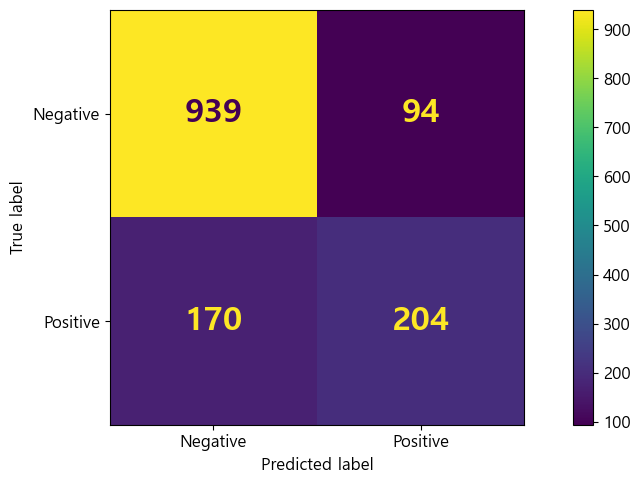


[학습곡선]


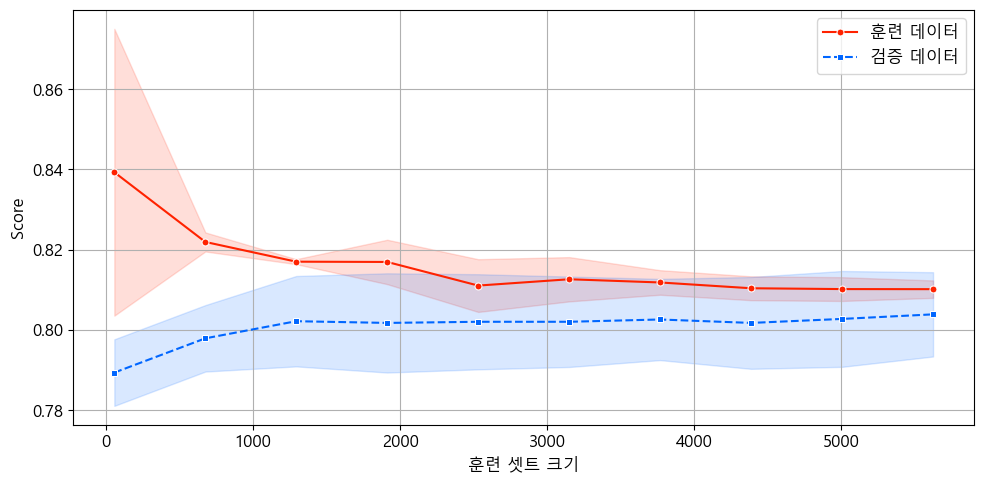

In [60]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state = 0, test_size = 0.2, stratify = Y)
model = my_logistic_classification(x_train, y_train, x_test, y_test, report = False)
add_result(model, '범주형 변수 결합', x_test, y_test)

### 3차항 추가

In [61]:
pf = PolynomialFeatures(degree = 3, include_bias = False)

In [62]:
tmp = df2[col_n]

In [63]:
tmp_df = pd.DataFrame(pf.fit_transform(tmp), columns = pf.get_feature_names_out(), index = df2.index)

In [64]:
df2.drop(col_n, axis = 1, inplace = True)
df2 = pd.concat([df2, tmp_df], axis = 1)

In [65]:
df2_p = pp.fit_transform(df2, yname = 'Churn', ylabeling = True)
X = df2_p.drop('Churn', axis = 1)
Y = df2_p['Churn']

데이터프레임 크기 : (7032, 39)
데이터프레임에 결측치는 없습니다.
연속형 데이터 컬럼 : ['tenure', 'MonthlyCharges', 'TotalCharges', 'tenure^2', 'tenure MonthlyCharges', 'tenure TotalCharges', 'MonthlyCharges^2', 'MonthlyCharges TotalCharges', 'TotalCharges^2', 'tenure^3', 'tenure^2 MonthlyCharges', 'tenure^2 TotalCharges', 'tenure MonthlyCharges^2', 'tenure MonthlyCharges TotalCharges', 'tenure TotalCharges^2', 'MonthlyCharges^3', 'MonthlyCharges^2 TotalCharges', 'MonthlyCharges TotalCharges^2', 'TotalCharges^3'], 총 19개
명목형 데이터 컬럼 : ['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'tenure_bin', 'MonthlyCharges_bin', 'TotalCharges_bin'], 총 19개
종속변수 컬럼명 : Churn / 종속변수 라벨링 여부 : True


[교차검증]
+----+-------+-----------+-------------------+
|    |     C | penalty   |   mean_test_score |
|----+-------+-----------+-------------------|
|  7 |   0.1 | l2        |          0.803733 |
| 16 |   100 | l2        |            0.8032 |
|  4 |  0.01 | l2        |          0.802844 |
| 10 |     1 | l2        |          0.802667 |
| 13 |    10 | l2        |          0.802489 |
|  1 | 0.001 | l2        |          0.789867 |
+----+-------+-----------+-------------------+

[분류분석 성능평가]
+-------------------------+--------------+--------------+-----------------------------------------------------------+
|                         |   훈련데이터 |   검증데이터 | 설명                                                      |
|-------------------------+--------------+--------------+-----------------------------------------------------------|
| 의사결정계수(Pseudo R2) |     0.287166 |     0.297129 | 로지스틱회귀의 성능 측정 지표로, 1에 가까울수록 좋은 모델 |
| 정확도(Accuracy)        |     0.806044 |     0.813788 | 예측 결과(TN,FP,TP,TN)가 실제 결과

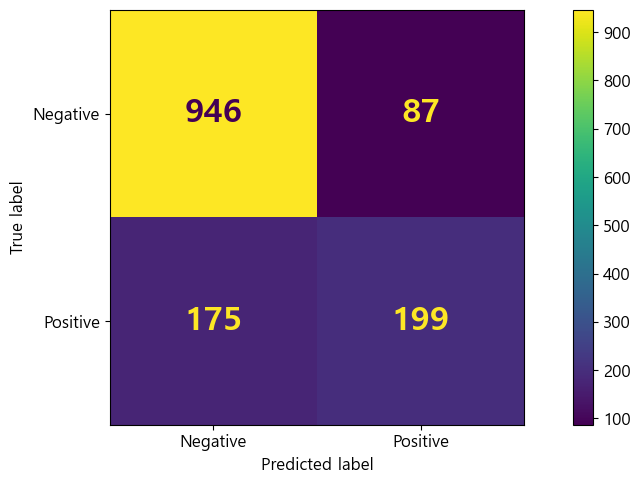


[학습곡선]


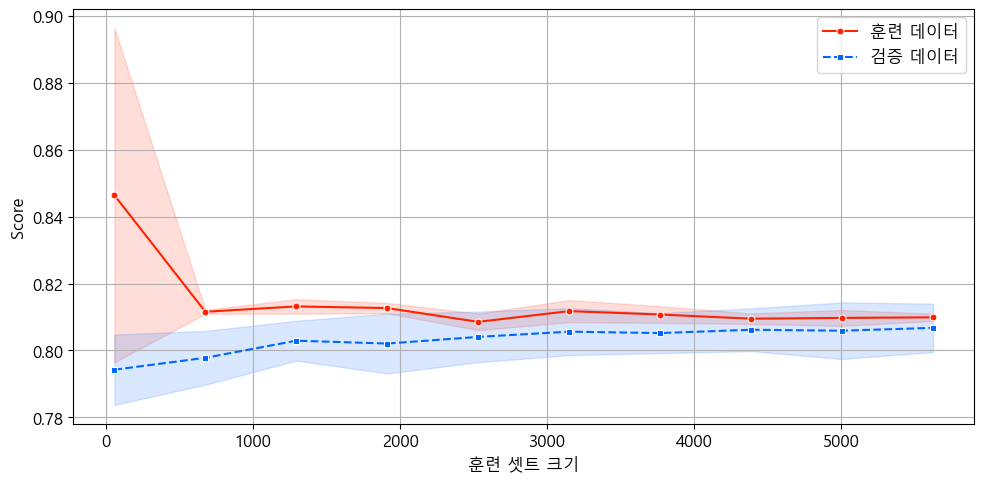

In [66]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state = 0, test_size = 0.2, stratify = Y)
model = my_logistic_classification(x_train, y_train, x_test, y_test, report = False)
add_result(model, '3차항 추가', x_test, y_test)

In [67]:
pd.DataFrame(results)

,How,Accuracy,Precision,ROC_AUC,model
0,원본 데이터,0.813788,0.687919,0.851370,"LogisticRegression(C=0.1, max_iter=500, n_jobs..."
1,Binning,0.815920,0.691030,0.853239,"LogisticRegression(C=0.1, max_iter=500, n_jobs..."
2,언더샘플링,0.752665,0.522569,0.851663,"LogisticRegression(C=1, max_iter=500, n_jobs=-1)"
3,오버샘플링,0.750533,0.520000,0.853736,"LogisticRegression(C=0.1, max_iter=500, n_jobs..."
4,SMOTE,0.750533,0.520000,0.853736,"LogisticRegression(C=0.1, max_iter=500, n_jobs..."
5,범주형 변수 결합,0.812367,0.684564,0.854049,"LogisticRegression(C=0.1, max_iter=500, n_jobs..."
6,3차항 추가,0.813788,0.695804,0.853943,"LogisticRegression(C=0.1, max_iter=500, n_jobs..."


### 전처리 스케일러, 인코더 변경

- 스케일러 : StandardScaler, MinMaxScaler, RobustScaler
- 인코더 : OneHotEncoder(더미화), OrdinalEncoder(라벨링)

In [68]:
pp_roll = YjkPreprocessor()

In [69]:
scaler_li = ['s', 'm', 'r']
encoder_li = ['o', 'ord']

In [70]:
results_pp = []

def add_result_pp(model, note, x_test, y_test):
    global results_pp
    tmp_dict = {}
    tmp_dict['How'] = note
    tmp_dict['Accuracy'] = model.score(x_test, y_test)
    tmp_dict['Precision'] = precision_score(y_test, model.predict(x_test))
    tmp_dict['ROC_AUC'] = roc_auc_score(y_test, model.predict_proba(x_test)[:, 1])
    tmp_dict['model'] = model
    results_pp.append(tmp_dict)

아래와 같이 처리합니다.
+-------------+----------------+
| 범주        | 처리방법       |
|-------------+----------------|
| 이상치 처리 | 처리하지 않음  |
| 결측치 처리 | 처리하지 않음  |
| 스케일러    | StandardScaler |
| 인코딩      | 원핫인코딩     |
+-------------+----------------+
[교차검증]
+----+-------+-----------+-------------------+
|    |     C | penalty   |   mean_test_score |
|----+-------+-----------+-------------------|
|  7 |   0.1 | l2        |          0.803733 |
| 16 |   100 | l2        |            0.8032 |
|  4 |  0.01 | l2        |          0.802844 |
| 10 |     1 | l2        |          0.802667 |
| 13 |    10 | l2        |          0.802489 |
|  1 | 0.001 | l2        |          0.789867 |
+----+-------+-----------+-------------------+

[분류분석 성능평가]
+-------------------------+--------------+--------------+-----------------------------------------------------------+
|                         |   훈련데이터 |   검증데이터 | 설명                                                      |
|-------------------------+--------------+------

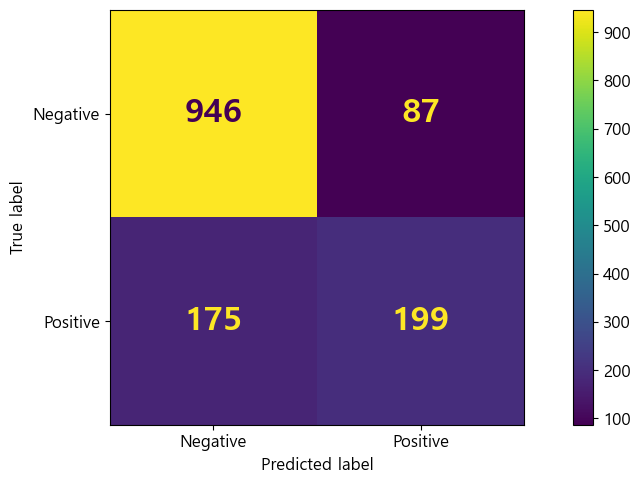

이미 Fit된 데이터가 있습니다. 객체에 데이터를 다시 입력하세요
아래와 같이 처리합니다.
+-------------+----------------+
| 범주        | 처리방법       |
|-------------+----------------|
| 이상치 처리 | 처리하지 않음  |
| 결측치 처리 | 처리하지 않음  |
| 스케일러    | StandardScaler |
| 인코딩      | 오디널인코딩   |
+-------------+----------------+
[교차검증]
+----+-------+-----------+-------------------+
|    |     C | penalty   |   mean_test_score |
|----+-------+-----------+-------------------|
|  7 |   0.1 | l2        |          0.801778 |
| 16 |   100 | l2        |          0.801778 |
| 10 |     1 | l2        |            0.8016 |
| 13 |    10 | l2        |          0.801067 |
|  4 |  0.01 | l2        |          0.798578 |
|  1 | 0.001 | l2        |          0.786311 |
+----+-------+-----------+-------------------+

[분류분석 성능평가]
+-------------------------+--------------+--------------+-----------------------------------------------------------+
|                         |   훈련데이터 |   검증데이터 | 설명                                                      |
|-----------

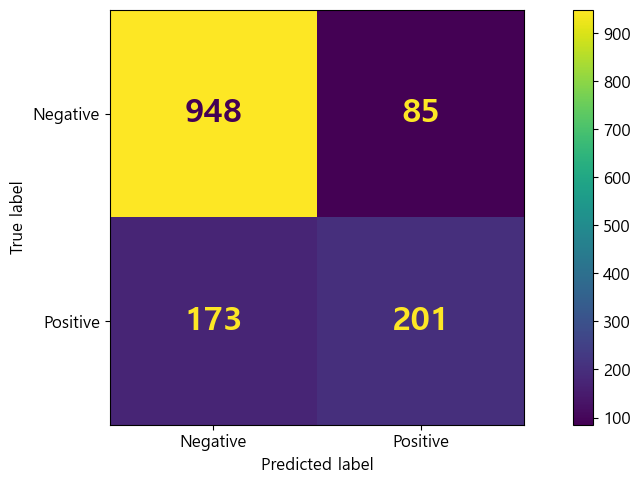

이미 Fit된 데이터가 있습니다. 객체에 데이터를 다시 입력하세요
아래와 같이 처리합니다.
+-------------+---------------+
| 범주        | 처리방법      |
|-------------+---------------|
| 이상치 처리 | 처리하지 않음 |
| 결측치 처리 | 처리하지 않음 |
| 스케일러    | MinMaxScaler  |
| 인코딩      | 원핫인코딩    |
+-------------+---------------+
[교차검증]
+----+-------+-----------+-------------------+
|    |     C | penalty   |   mean_test_score |
|----+-------+-----------+-------------------|
|  7 |   0.1 | l2        |          0.804089 |
| 10 |     1 | l2        |          0.803556 |
| 13 |    10 | l2        |          0.802667 |
| 16 |   100 | l2        |          0.801422 |
|  4 |  0.01 | l2        |          0.795378 |
|  1 | 0.001 | l2        |          0.761244 |
+----+-------+-----------+-------------------+

[분류분석 성능평가]
+-------------------------+--------------+--------------+-----------------------------------------------------------+
|                         |   훈련데이터 |   검증데이터 | 설명                                                      |
|------------------

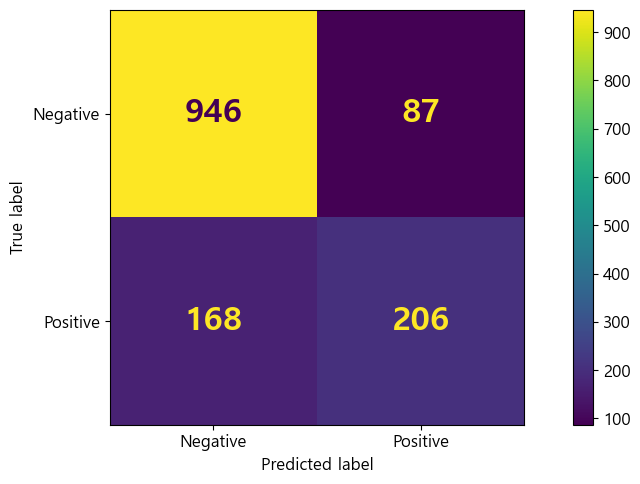

이미 Fit된 데이터가 있습니다. 객체에 데이터를 다시 입력하세요
아래와 같이 처리합니다.
+-------------+---------------+
| 범주        | 처리방법      |
|-------------+---------------|
| 이상치 처리 | 처리하지 않음 |
| 결측치 처리 | 처리하지 않음 |
| 스케일러    | MinMaxScaler  |
| 인코딩      | 오디널인코딩  |
+-------------+---------------+
[교차검증]
+----+-------+-----------+-------------------+
|    |     C | penalty   |   mean_test_score |
|----+-------+-----------+-------------------|
|  7 |   0.1 | l2        |          0.803556 |
| 13 |    10 | l2        |          0.802133 |
| 10 |     1 | l2        |          0.801778 |
| 16 |   100 | l2        |          0.800889 |
|  4 |  0.01 | l2        |          0.789689 |
|  1 | 0.001 | l2        |          0.752889 |
+----+-------+-----------+-------------------+

[분류분석 성능평가]
+-------------------------+--------------+--------------+-----------------------------------------------------------+
|                         |   훈련데이터 |   검증데이터 | 설명                                                      |
|-------------------

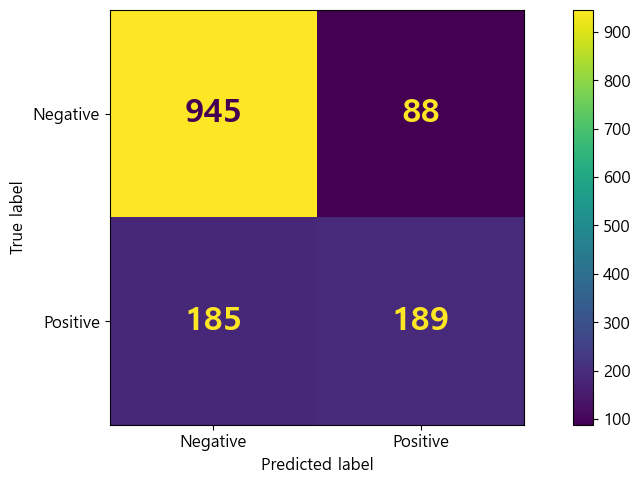

이미 Fit된 데이터가 있습니다. 객체에 데이터를 다시 입력하세요
아래와 같이 처리합니다.
+-------------+---------------+
| 범주        | 처리방법      |
|-------------+---------------|
| 이상치 처리 | 처리하지 않음 |
| 결측치 처리 | 처리하지 않음 |
| 스케일러    | RobustScaler  |
| 인코딩      | 원핫인코딩    |
+-------------+---------------+
[교차검증]
+----+-------+-----------+-------------------+
|    |     C | penalty   |   mean_test_score |
|----+-------+-----------+-------------------|
|  7 |   0.1 | l2        |          0.803733 |
| 16 |   100 | l2        |          0.803022 |
| 13 |    10 | l2        |          0.802311 |
| 10 |     1 | l2        |          0.801244 |
|  4 |  0.01 | l2        |          0.799289 |
|  1 | 0.001 | l2        |          0.781511 |
+----+-------+-----------+-------------------+

[분류분석 성능평가]
+-------------------------+--------------+--------------+-----------------------------------------------------------+
|                         |   훈련데이터 |   검증데이터 | 설명                                                      |
|------------------

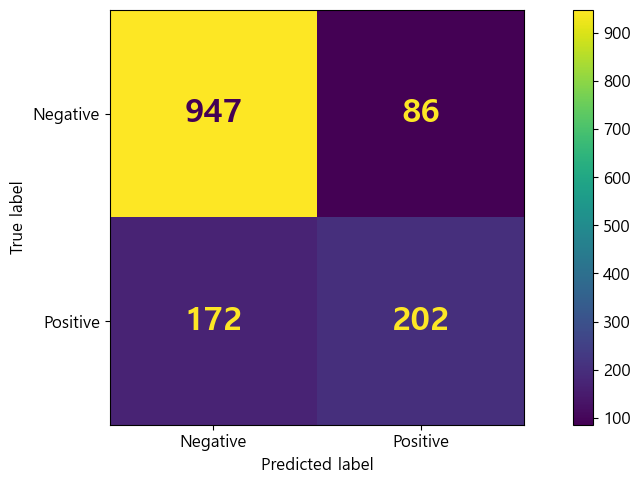

이미 Fit된 데이터가 있습니다. 객체에 데이터를 다시 입력하세요
아래와 같이 처리합니다.
+-------------+---------------+
| 범주        | 처리방법      |
|-------------+---------------|
| 이상치 처리 | 처리하지 않음 |
| 결측치 처리 | 처리하지 않음 |
| 스케일러    | RobustScaler  |
| 인코딩      | 오디널인코딩  |
+-------------+---------------+
[교차검증]
+----+-------+-----------+-------------------+
|    |     C | penalty   |   mean_test_score |
|----+-------+-----------+-------------------|
|  7 |   0.1 | l2        |          0.803378 |
| 10 |     1 | l2        |          0.802667 |
| 16 |   100 | l2        |            0.8016 |
| 13 |    10 | l2        |               0.8 |
|  4 |  0.01 | l2        |          0.795911 |
|  1 | 0.001 | l2        |          0.779022 |
+----+-------+-----------+-------------------+

[분류분석 성능평가]
+-------------------------+--------------+--------------+-----------------------------------------------------------+
|                         |   훈련데이터 |   검증데이터 | 설명                                                      |
|-------------------

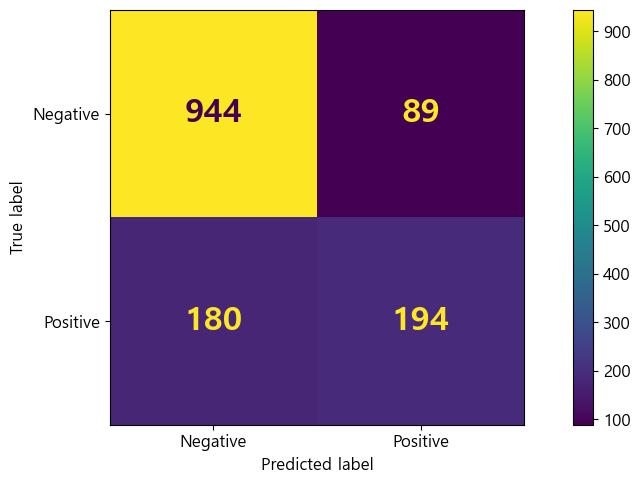

In [71]:
for i in scaler_li:
    for j in encoder_li:
        pp_roll.set_strategy(outline = None, null = None, encoder = j, scaler = i, alert = True)
        df2_p = pp_roll.fit_transform(df2, yname = 'Churn', ylabeling = True, alert = False)
        X = df2_p.drop('Churn', axis = 1)
        Y = df2_p['Churn']

        x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state = 0, test_size = 0.2, stratify = Y)
        model = my_logistic_classification(x_train, y_train, x_test, y_test, report = False, learning_curve = False)
        add_result_pp(model, f"Scaler : {i}, Encoder : {j}", x_test, y_test)

In [72]:
pd.DataFrame(results_pp)

,How,Accuracy,Precision,ROC_AUC,model
0,"Scaler : s, Encoder : o",0.813788,0.695804,0.853943,"LogisticRegression(C=0.1, max_iter=500, n_jobs..."
1,"Scaler : s, Encoder : ord",0.816631,0.702797,0.852620,"LogisticRegression(C=0.1, max_iter=500, n_jobs..."
2,"Scaler : m, Encoder : o",0.818763,0.703072,0.852162,"LogisticRegression(C=0.1, max_iter=500, n_jobs..."
3,"Scaler : m, Encoder : ord",0.805970,0.682310,0.850487,"LogisticRegression(C=0.1, max_iter=500, n_jobs..."
4,"Scaler : r, Encoder : o",0.816631,0.701389,0.853280,"LogisticRegression(C=0.1, max_iter=500, n_jobs..."
5,"Scaler : r, Encoder : ord",0.808813,0.685512,0.852038,"LogisticRegression(C=0.1, max_iter=500, n_jobs..."


- MinMaxScaler / 더미화의 정확도 및 정밀도 성능이 가장 우수했음

## 최종 모델 및 성능 확인

In [73]:
pp_final = YjkPreprocessor()
pp_final.set_strategy(outline = None, null = None, scaler = 'm', encoder = 'o')

아래와 같이 처리합니다.
+-------------+---------------+
| 범주        | 처리방법      |
|-------------+---------------|
| 이상치 처리 | 처리하지 않음 |
| 결측치 처리 | 처리하지 않음 |
| 스케일러    | MinMaxScaler  |
| 인코딩      | 원핫인코딩    |
+-------------+---------------+


데이터프레임 크기 : (7032, 39)
데이터프레임에 결측치는 없습니다.
연속형 데이터 컬럼 : ['tenure', 'MonthlyCharges', 'TotalCharges', 'tenure^2', 'tenure MonthlyCharges', 'tenure TotalCharges', 'MonthlyCharges^2', 'MonthlyCharges TotalCharges', 'TotalCharges^2', 'tenure^3', 'tenure^2 MonthlyCharges', 'tenure^2 TotalCharges', 'tenure MonthlyCharges^2', 'tenure MonthlyCharges TotalCharges', 'tenure TotalCharges^2', 'MonthlyCharges^3', 'MonthlyCharges^2 TotalCharges', 'MonthlyCharges TotalCharges^2', 'TotalCharges^3'], 총 19개
명목형 데이터 컬럼 : ['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'tenure_bin', 'MonthlyCharges_bin', 'TotalCharges_bin'], 총 19개
종속변수 컬럼명 : Churn / 종속변수 라벨링 여부 : True
[교차검증]
+----+-------+-----------+-------------------+
|    |     C | penalty   |   mean_test_score |
|----+-------+-----------+--------

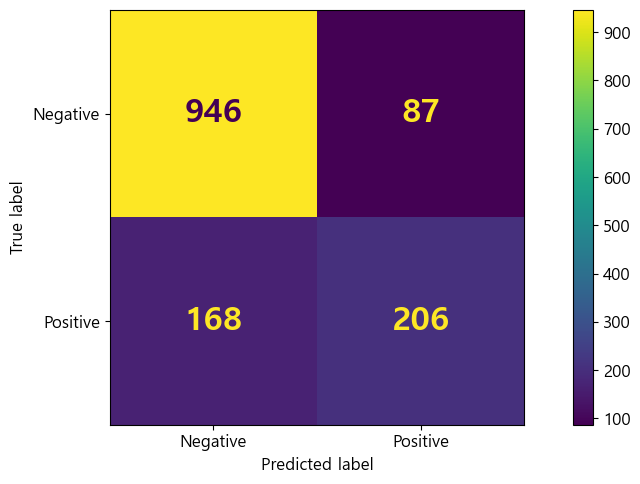


[학습곡선]


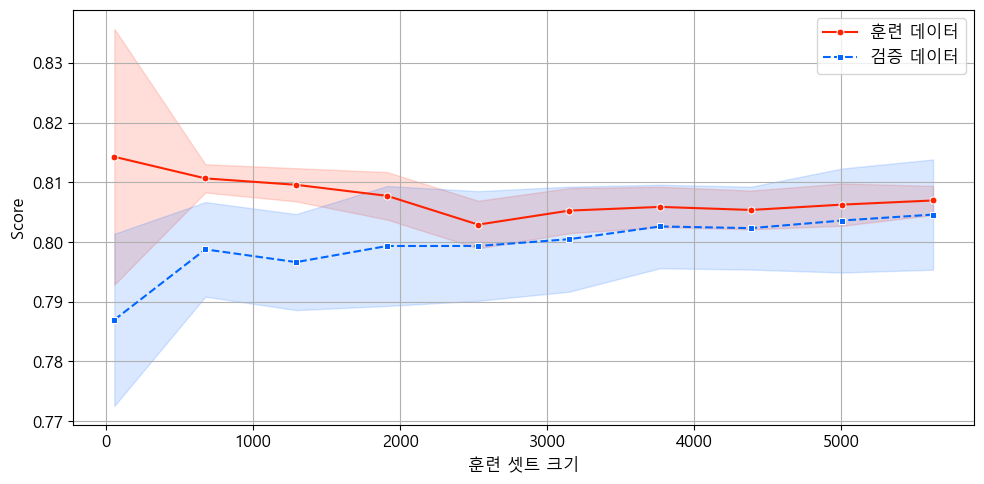

LinAlgError: Singular matrix

In [74]:
df2_p = pp_final.fit_transform(df2, yname = 'Churn', ylabeling = True)
X = df2_p.drop('Churn', axis = 1)
Y = df2_p['Churn']

x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state = 0, test_size = 0.2, stratify = Y)
model = my_logistic_classification(x_train, y_train, x_test, y_test, report = True, learning_curve = True)

- 최종 정확도 : 0.818763
- 최종 정밀도 : 0.704467

In [75]:
support = YjkClassifierSupport()

사용 가능한 모델 : ['LogisticRegression', 'SGDClassifier', 'KNeighborsClassifier', 'LinearSVC', 'SVC', 'GaussianNB', 'DecisionTreeClassifier', 'CatboostClassifier']


In [76]:
result_df = yjk_classifier_multi_gridsearch(support, x_train, y_train, x_test, y_test, randomized_search = True, include_models = 'all', secondary_score = ['roc_auc', 'recall', 'precision'])

LogisticRegression 모델 소요 시간 : 0:00:02
SGDClassifier 모델 소요 시간 : 0:00:00
KNeighborsClassifier 모델 소요 시간 : 0:00:01
LinearSVC 모델 소요 시간 : 0:00:12
SVC 모델 소요 시간 : 0:00:25
GaussianNB 모델 소요 시간 : 0:00:00
DecisionTreeClassifier 모델 소요 시간 : 0:00:00
CatboostClassifier 모델 소요 시간 : 0:00:10
총 소요 시간 : 0:00:55


In [77]:
result_df

,best_model,best_param,accuracy_train,accuracy_test,roc_auc_train,roc_auc_test,recall_train,recall_test,precision_train,precision_test
model_name,,,,,,,,,,
LogisticRegression,"LogisticRegression(C=0.1, n_jobs=-1)","{'penalty': 'l2', 'max_iter': 100, 'C': 0.1}",0.804972,0.818763,0.846288,0.852162,0.537793,0.550802,0.667774,0.703072
LinearSVC,"LinearSVC(C=0.01, dual=True, random_state=0)","{'penalty': 'l2', 'max_iter': 1000, 'loss': 's...",0.802484,0.813077,NaN,NaN,0.507692,0.518717,0.663462,0.700361
SGDClassifier,"SGDClassifier(alpha=0.01, loss='log_loss', max...","{'tol': 0.0001, 'penalty': 'l2', 'max_iter': 5...",0.798573,0.805970,0.840222,0.846553,0.517057,0.508021,0.653976,0.681004
SVC,"SVC(C=1, degree=2)","{'kernel': 'rbf', 'degree': 2, 'C': 1}",0.801242,0.801706,NaN,NaN,0.523746,0.467914,0.713765,0.686275
CatboostClassifier,<catboost.core.CatBoostClassifier object at 0x...,{},0.799462,0.799574,0.941975,0.845608,0.684950,0.497326,0.829150,0.664286
DecisionTreeClassifier,"DecisionTreeClassifier(criterion='entropy', ma...","{'splitter': 'best', 'min_samples_split': 5, '...",0.790392,0.793888,0.865074,0.803953,0.543813,0.491979,0.680905,0.647887
KNeighborsClassifier,"KNeighborsClassifier(n_jobs=-1, n_neighbors=6,...","{'weights': 'uniform', 'p': 1, 'n_neighbors': 6}",0.776884,0.769723,0.894962,0.797431,0.551839,0.419786,0.775376,0.594697
GaussianNB,GaussianNB(),{'var_smoothing': 1e-09},0.689411,0.708600,0.808590,0.816115,0.820736,0.826203,0.452434,0.472477


In [88]:
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

In [91]:
rf = RandomForestClassifier(random_state = 0)
xgb = XGBClassifier(random_state = 0)
lgbm = LGBMClassifier(random_state = 0, verbose = -1)

In [84]:
params = [i for i in range(1, 11)] + [10 * i for i in range(2, 11)]
params

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]

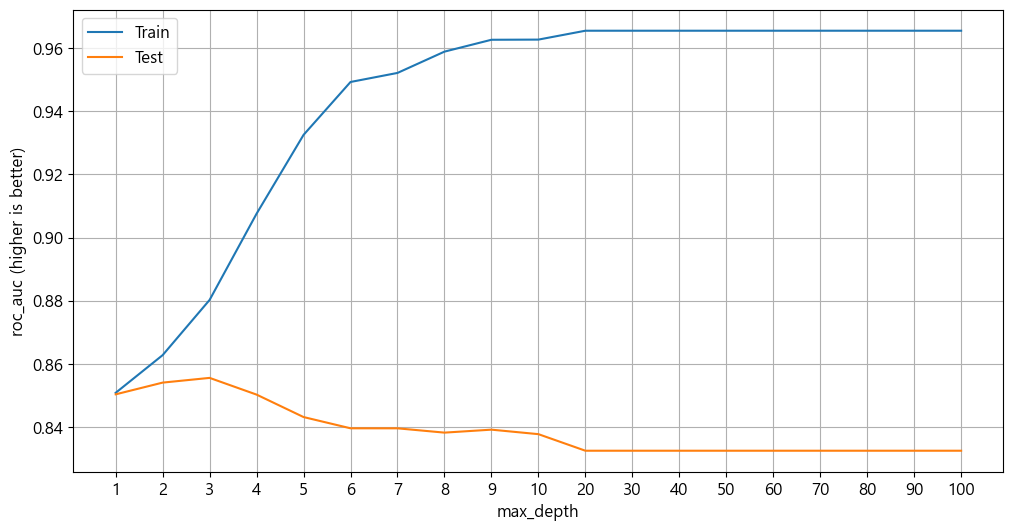

,훈련 데이터,검증 데이터,Min-Max
max_depth,,,
1,0.850780,0.850298,
2,0.862724,0.854015,
3,0.880232,0.855511,최대값
4,0.907564,0.850210,
5,0.932548,0.843096,
6,0.949317,0.839532,
7,0.952185,0.839524,
8,0.958935,0.838159,
9,0.962699,0.839101,


In [98]:
yjk_classification_param_plot(lgbm, x_train, y_train, 'max_depth', params, x_test, y_test, scoring = 'roc_auc')

In [99]:
from hossam.classification import *

In [100]:
my_classification(x_train, y_train, x_test, y_test)

<class 'sklearn.svm._classes.SVC'>는 n_jobs를 허용하지 않음
<class 'sklearn.naive_bayes.GaussianNB'>는 n_jobs를 허용하지 않음
<class 'sklearn.tree._classes.DecisionTreeClassifier'>는 n_jobs를 허용하지 않음
+------------------------+---------------------------+--------------------+---------------------+------------------+---------------------+---------------+------------+----------+
|                        |   의사결정계수(Pseudo R2) |   정확도(Accuracy) |   정밀도(Precision) |   재현율(Recall) |   위양성율(Fallout) |   특이성(TNR) |   F1 Score |      AUC |
|------------------------+---------------------------+--------------------+---------------------+------------------+---------------------+---------------+------------+----------|
| GaussianNB             |                         0 |             0.7086 |            0.472477 |         0.826203 |            0.333979 |      0.666021 |   0.601167 | 0.816115 |
| DecisionTreeClassifier |                         0 |           0.730633 |            0.493225 |         0.486631 |        

{'GaussianNB': GaussianNB(),
 'DecisionTreeClassifier': DecisionTreeClassifier(),
 'KNeighborsClassifier': KNeighborsClassifier(metric='euclidean', n_jobs=-1, n_neighbors=7),
 'LogisticRegression': LogisticRegression(C=0.1, max_iter=1000, n_jobs=-1),
 'SVC': SVC(C=1, degree=2, kernel='poly')}